# Predicting Physical Activity Levels and Intervention Success of the PE4MOVE Study in Adolescents Using Machine Learning

## Research Objectives

This notebook implements a comprehensive machine learning analysis to:

1. **Predict intervention success**: Develop models to predict changes in physical activity (ΔPA) from baseline to follow-up
2. **Identify key predictors**: Determine which baseline characteristics most strongly predict intervention response
3. **Inform intervention design**: Provide insights for personalizing school-based physical activity interventions

## Machine Learning Workflow

Our analysis follows best practices for model development and evaluation:

1. **Data Preparation**: Load and prepare features and target variables
2. **Train/Test Split**: Reserve 20% of data for final evaluation (test set never used for model selection)
3. **Baseline Training**: Train all models with default parameters using 5-fold cross-validation
4. **Model Selection**: Select best-performing models based on CV performance on training data
5. **Hyperparameter Tuning**: Optimize only the best models using GridSearchCV with 5-fold CV
6. **Final Evaluation**: Assess tuned models on the held-out test set
7. **Feature Importance**: Analyze which features drive predictions

## Target Variables

We predict four physical activity outcomes:
- **ΔMVPA Frequency**: Change in moderate-to-vigorous physical activity frequency
- **ΔMVPA Usual Week**: Change in MVPA during a typical week
- **ΔLeisure Exercise**: Change in leisure-time exercise
- **ΔLeisure PA**: Change in overall leisure-time physical activity


## 1. Import Libraries and Setup

In [170]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# Set visualization style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

print("Libraries imported successfully!")
print(f"Random state: {RANDOM_STATE}")

Libraries imported successfully!
Random state: 42


## 2. Data Loading 

Load the preprocessed dataset containing:


In [171]:
# Load the clean dataset
data = pd.read_csv('data/intervention_group_clean.csv')

print(f"Dataset shape: {data.shape}")
print(f"Number of participants: {len(data)}")
print(f"\nTarget variables (Delta scores):")
delta_cols = [col for col in data.columns if col.startswith('Delta_')]
print(f"  {delta_cols}")
print(f"\nNumber of features: {len(data.columns) - len(delta_cols)}")

# Display first few rows
data.head()

Dataset shape: (697, 28)
Number of participants: 697

Target variables (Delta scores):
  ['Delta_MVPA_Frequency', 'Delta_MVPA_Usual_Week', 'Delta_Leisure_Exercise', 'Delta_Leisure_PA']

Number of features: 24


,Age,Sex,MVPA_Frequency_T0,Leisure_Exercise_T0,YAP_sedentary_general_T0,Leisure_PA_T0,MVPA_Usual_Week_T0,Group_Final,MVPA_Frequency_T1,MVPA_Usual_Week_T1,...,HG_Average_T0,MVPA_Improvement,Motivation_T0,Self_Monitoring_T0,Delta_MVPA_Frequency,Delta_MVPA_Usual_Week,Delta_Leisure_Exercise,Delta_Leisure_PA,BMI_for_age_zscore,BMI_category
0,11,2,3,0,2,3,3,A,3.0,2.0,...,52.5,0.0,12.333333,4.25,0.0,-1.0,3.0,0.0,-0.710593,Normal
1,11,2,2,4,2,3,3,A,3.0,3.0,...,22.0,1.0,4.000000,4.50,1.0,0.0,0.0,0.0,1.880262,Overweight
2,11,2,4,5,2,3,4,A,4.0,4.0,...,19.0,0.0,13.166667,4.00,0.0,0.0,-1.0,1.0,-0.373834,Normal
3,11,1,3,4,3,3,3,A,3.0,3.0,...,50.0,0.0,13.500000,5.00,0.0,0.0,-1.0,0.0,0.782698,Normal
4,11,1,1,0,2,3,2,A,3.0,3.0,...,13.0,2.0,3.666667,2.25,2.0,1.0,3.0,0.0,1.899928,Overweight


## 3. Feature Selection and Encoding

### 3.1. Feature Selectin - delta and baseline

In [172]:
# Define baseline features (exclude delta variables)
delta_columns = [col for col in data.columns if col.startswith('Delta_')]
baseline_features = [col for col in data.columns if col not in delta_columns and col not in ['Group_Final','MVPA_Usual_Week_T1', 'MVPA_Frequency_T1', 'Leisure_Exercise_T1', 'Leisure_PA_T1', 'MVPA_Improvement']]

print(f"Total baseline features: {len(baseline_features)}")
print(f"\nFeature list:")
for i, feat in enumerate(baseline_features, 1):
    print(f"  {i}. {feat}")

# Define target variables
target_variables = {
    'Delta_MVPA_Frequency': 'ΔMVPA Frequency',
    'Delta_MVPA_Usual_Week': 'ΔMVPA Usual Week',
    'Delta_Leisure_Exercise': 'ΔLeisure Exercise',
    'Delta_Leisure_PA': 'ΔLeisure PA'
}

print(f"\nTarget variables: {list(target_variables.keys())}")

Total baseline features: 18

Feature list:
  1. Age
  2. Sex
  3. MVPA_Frequency_T0
  4. Leisure_Exercise_T0
  5. YAP_sedentary_general_T0
  6. Leisure_PA_T0
  7. MVPA_Usual_Week_T0
  8. PE_hours_T0
  9. Extracurricular_Session_Coach_T0
  10. Extracurricular_Session_School_T0
  11. COVID_impact_T0
  12. SixMW_T0
  13. SLJ_T0
  14. HG_Average_T0
  15. Motivation_T0
  16. Self_Monitoring_T0
  17. BMI_for_age_zscore
  18. BMI_category

Target variables: ['Delta_MVPA_Frequency', 'Delta_MVPA_Usual_Week', 'Delta_Leisure_Exercise', 'Delta_Leisure_PA']


### 3.2. Data Encoding
Convert all non-float features to float for optimal model training.

In [173]:
# Check current data types
print("Current data types:")
print(data.dtypes.value_counts())
print("\nString/Object columns:")
string_cols = data.select_dtypes(include=['object', 'string']).columns.tolist()
print(f"  {string_cols}")

# Encode categorical variables to numeric codes
print("\nEncoding categorical variables to numeric codes...")
encoding_map = {}

for col in string_cols:
    # Get unique values
    unique_values = data[col].dropna().unique()
    print(f"\n{col}:")
    print(f"  Unique values: {unique_values}")
    
    # Create mapping (alphabetical order for consistency)
    sorted_values = sorted([v for v in unique_values if pd.notna(v)])
    col_encoding = {val: idx + 1 for idx, val in enumerate(sorted_values)}
    encoding_map[col] = col_encoding
    
    # Display encoding
    print(f"  Encoding: {col_encoding}")
    
    # Apply encoding
    data[col] = data[col].map(col_encoding)

print(f"\nDataset shape: {data.shape}")
print("\nEncoding complete!")

# Display encoding reference
print("\n" + "="*60)
print("ENCODING REFERENCE:")
print("="*60)
for col, mapping in encoding_map.items():
    print(f"\n{col}:")
    for val, code in mapping.items():
        print(f"  {val} -> {code}")

Current data types:
float64    14
int64      12
object      2
Name: count, dtype: int64

String/Object columns:
  ['Group_Final', 'BMI_category']

Encoding categorical variables to numeric codes...

Group_Final:
  Unique values: ['A']
  Encoding: {'A': 1}

BMI_category:
  Unique values: ['Normal' 'Overweight' 'Below normal' 'Thinness' 'Obesity']
  Encoding: {'Below normal': 1, 'Normal': 2, 'Obesity': 3, 'Overweight': 4, 'Thinness': 5}

Dataset shape: (697, 28)

Encoding complete!

ENCODING REFERENCE:

Group_Final:
  A -> 1

BMI_category:
  Below normal -> 1
  Normal -> 2
  Obesity -> 3
  Overweight -> 4
  Thinness -> 5


## 4. Machine Learning Pipeline

### Model Selection Strategy

We evaluate 7 different algorithms to capture both linear and non-linear relationships:

**Linear Models:**
1. **Ridge Regression**: L2 regularization, handles multicollinearity
2. **Lasso Regression**: L1 regularization, performs feature selection
3. **ElasticNet**: Combines L1 and L2 regularization

**Non-Linear Models:**

4. **Random Forest**: Ensemble of decision trees, captures interactions
5. **Gradient Boosting**: Sequential tree building, high predictive power
6. **Support Vector Regression (SVR)**: Kernel-based, captures complex patterns
7. **K-Nearest Neighbors (K-NN)**: Instance-based, local patterns

### Evaluation Strategy

**Phase 1: Baseline Training**
- Train all 7 models with default parameters
- Use 5-fold cross-validation on training data (80%)
- Identify top-performing models based on CV R²

**Phase 2: Hyperparameter Tuning**
- Select top 3 models from baseline training
- Perform GridSearchCV with 5-fold CV on training data
- Optimize hyperparameters for each selected model

**Phase 3: Final Evaluation**
- Evaluate tuned models on held-out test set (20%)
- Test set used ONLY for final performance assessment
- Report R², MAE, and RMSE on test data

**Important**: Model selection is based entirely on CV performance on the training set. The test set is reserved exclusively for final evaluation to prevent data leakage and overfitting.


### 4.1. Phase 1: Baseline Model Training

Train all models with default parameters to identify top performers.

In [174]:
def baseline_training(X, y, target_name, test_size=0.2, random_state=42):
    """
    Train all models with default parameters using cross-validation.
    
    Returns:
        - cv_results: DataFrame with CV scores for each model
        - X_train, X_test, y_train, y_test: Split data
        - scaler: Fitted scaler
    """
    
    # Split data (test set reserved for final evaluation only)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state
    )
    
    # Standardize features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Define models with default parameters
    models = {
        'Ridge': Ridge(random_state=random_state),
        'Lasso': Lasso(random_state=random_state),
        'ElasticNet': ElasticNet(random_state=random_state),
        'Random Forest': RandomForestRegressor(random_state=random_state, n_jobs=-1),
        'Gradient Boosting': GradientBoostingRegressor(random_state=random_state),
        'SVR': SVR(),
        'K-NN': KNeighborsRegressor()
    }
    
    # Perform 5-fold CV on training data
    cv_results = []
    
    print(f"\n{'='*60}")
    print(f"Baseline Training: {target_name}")
    print(f"{'='*60}")
    print(f"Training set size: {len(X_train)} | Test set size: {len(X_test)}")
    print(f"\nPerforming 5-fold cross-validation on training data...\n")
    
    for name, model in models.items():
        # 5-fold CV on training data only
        cv_scores = cross_val_score(
            model, X_train_scaled, y_train, 
            cv=5, scoring='r2', n_jobs=-1
        )
        
        mean_cv_r2 = cv_scores.mean()
        std_cv_r2 = cv_scores.std()
        
        cv_results.append({
            'Model': name,
            'CV_R2_Mean': mean_cv_r2,
            'CV_R2_Std': std_cv_r2
        })
        
        print(f"{name:20s} - CV R²: {mean_cv_r2:.4f} (+/- {std_cv_r2:.4f})")
    
    cv_results_df = pd.DataFrame(cv_results).sort_values('CV_R2_Mean', ascending=False)
    
    print(f"\nTop 3 models selected for hyperparameter tuning:")
    for i, row in cv_results_df.head(3).iterrows():
        print(f"  {row['Model']:20s} - CV R²: {row['CV_R2_Mean']:.4f}")
    
    return cv_results_df, X_train_scaled, X_test_scaled, y_train, y_test, scaler

print("Baseline training function defined.")

Baseline training function defined.


### 4.2. Phase 2: Hyperparameter Tuning

Optimize the top 3 models from baseline training using GridSearchCV.

In [175]:
def hyperparameter_tuning(X_train, y_train, top_models, target_name, random_state=42):
    """
    Perform hyperparameter tuning for top performing models.
    
    Args:
        X_train: Training features (scaled)
        y_train: Training target
        top_models: List of top model names from baseline training
        target_name: Name of target variable
    
    Returns:
        best_models: Dictionary of tuned models
        tuning_results: DataFrame with tuning results
    """
    
    # Define hyperparameter grids
    param_grids = {
        'Ridge': {
            'alpha': [0.001, 0.01, 0.1, 1, 10, 100, 1000]
        },
        'Lasso': {
            'alpha': [0.001, 0.01, 0.1, 1, 10, 100]
        },
        'ElasticNet': {
            'alpha': [0.001, 0.01, 0.1, 1, 10],
            'l1_ratio': [0.1, 0.3, 0.5, 0.7, 0.9]
        },
        'Random Forest': {
            'n_estimators': [100, 200, 300],
            'max_depth': [10, 20, 30, None],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4]
        },
        'Gradient Boosting': {
            'n_estimators': [100, 200, 300],
            'learning_rate': [0.01, 0.05, 0.1],
            'max_depth': [3, 5, 7],
            'min_samples_split': [2, 5, 10]
        },
        'SVR': {
            'C': [0.1, 1, 10, 100],
            'gamma': ['scale', 'auto', 0.001, 0.01],
            'epsilon': [0.01, 0.1, 0.2]
        },
        'K-NN': {
            'n_neighbors': [3, 5, 7, 9, 11, 15],
            'weights': ['uniform', 'distance'],
            'p': [1, 2]
        }
    }
    
    # Define base models
    base_models = {
        'Ridge': Ridge(random_state=random_state),
        'Lasso': Lasso(random_state=random_state),
        'ElasticNet': ElasticNet(random_state=random_state),
        'Random Forest': RandomForestRegressor(random_state=random_state, n_jobs=-1),
        'Gradient Boosting': GradientBoostingRegressor(random_state=random_state),
        'SVR': SVR(),
        'K-NN': KNeighborsRegressor()
    }
    
    print(f"\n{'='*60}")
    print(f"Hyperparameter Tuning: {target_name}")
    print(f"{'='*60}")
    print(f"Tuning top 3 models using GridSearchCV with 5-fold CV...\n")
    
    best_models = {}
    tuning_results = []
    
    for model_name in top_models:
        print(f"Tuning {model_name}...")
        
        grid_search = GridSearchCV(
            base_models[model_name],
            param_grids[model_name],
            cv=5,
            scoring='r2',
            n_jobs=-1,
            verbose=0
        )
        
        grid_search.fit(X_train, y_train)
        
        best_models[model_name] = grid_search.best_estimator_
        
        tuning_results.append({
            'Model': model_name,
            'Best_CV_R2': grid_search.best_score_,
            'Best_Params': grid_search.best_params_
        })
        
        print(f"  Best CV R²: {grid_search.best_score_:.4f}")
        print(f"  Best params: {grid_search.best_params_}")
        print()
    
    tuning_results_df = pd.DataFrame(tuning_results).sort_values('Best_CV_R2', ascending=False)
    
    return best_models, tuning_results_df

print("Hyperparameter tuning function defined.")

Hyperparameter tuning function defined.


### 4.3. Phase 3: Final Evaluation on Test Set

Evaluate tuned models on the held-out test set for unbiased performance estimation.

In [176]:
def final_evaluation(best_models, X_test, y_test, target_name):
    """
    Evaluate tuned models on held-out test set.
    
    Returns:
        results_df: DataFrame with test set performance
        predictions: Dictionary of predictions for each model
    """
    
    print(f"\n{'='*60}")
    print(f"Final Evaluation on Test Set: {target_name}")
    print(f"{'='*60}")
    print(f"Test set size: {len(y_test)}\n")
    
    results = []
    predictions = {}
    
    for name, model in best_models.items():
        # Predict on test set
        y_pred = model.predict(X_test)
        predictions[name] = y_pred
        
        # Calculate metrics
        r2 = r2_score(y_test, y_pred)
        mae = mean_absolute_error(y_test, y_pred)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        
        results.append({
            'Model': name,
            'Test_R2': r2,
            'Test_MAE': mae,
            'Test_RMSE': rmse
        })
        
        print(f"{name:20s} - R²: {r2:.4f} | MAE: {mae:.4f} | RMSE: {rmse:.4f}")
    
    results_df = pd.DataFrame(results).sort_values('Test_R2', ascending=False)
    
    print(f"\nBest model on test set: {results_df.iloc[0]['Model']}")
    print(f"Test R²: {results_df.iloc[0]['Test_R2']:.4f}")
    
    return results_df, predictions

print("Final evaluation function defined.")

Final evaluation function defined.


## 5. Feature Importance Analysis

Extract feature importance from the best performing model.

In [177]:
def get_feature_importance(model, feature_names, model_name, target_name, top_n=20):
    """Extract and visualize feature importance for tree-based models."""
    
    if not hasattr(model, 'feature_importances_'):
        print(f"{model_name} does not support feature importance extraction.")
        return None
    
    importance = model.feature_importances_
    feature_importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importance
    }).sort_values('Importance', ascending=False).head(top_n)
    
    plt.figure(figsize=(10, 8))
    plt.barh(range(len(feature_importance_df)), feature_importance_df['Importance'])
    plt.yticks(range(len(feature_importance_df)), feature_importance_df['Feature'])
    plt.xlabel('Importance Score')
    plt.title(f'Top {top_n} Features - {model_name} - {target_name}')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()
    
    return feature_importance_df

print("Feature importance function defined.")

Feature importance function defined.


## 6. Visualization Functions

In [178]:
def plot_model_comparison(results_df, target_name, metric='Test_R2'):
    """Visualize model performance comparison."""
    plt.figure(figsize=(10, 6))
    plt.bar(results_df['Model'], results_df[metric], color='steelblue', alpha=0.7)
    plt.xlabel('Model')
    plt.ylabel(metric.replace('_', ' '))
    plt.title(f'Model Comparison - {target_name}')
    plt.xticks(rotation=45, ha='right')
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.show()

def plot_predictions(y_test, predictions, model_name, target_name):
    """Plot actual vs predicted values."""
    plt.figure(figsize=(8, 8))
    plt.scatter(y_test, predictions, alpha=0.5, s=30)
    min_val = min(y_test.min(), predictions.min())
    max_val = max(y_test.max(), predictions.max())
    plt.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='Perfect Prediction')
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title(f'Prediction Quality - {model_name} - {target_name}')
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

print("Visualization functions defined.")

Visualization functions defined.


## 7. Analysis of Prediction Results

### 7.1. Analysis: ΔMVPA Frequency

Complete machine learning pipeline for predicting δmvpa frequency.

In [179]:
print(baseline_features)

['Age', 'Sex', 'MVPA_Frequency_T0', 'Leisure_Exercise_T0', 'YAP_sedentary_general_T0', 'Leisure_PA_T0', 'MVPA_Usual_Week_T0', 'PE_hours_T0', 'Extracurricular_Session_Coach_T0', 'Extracurricular_Session_School_T0', 'COVID_impact_T0', 'SixMW_T0', 'SLJ_T0', 'HG_Average_T0', 'Motivation_T0', 'Self_Monitoring_T0', 'BMI_for_age_zscore', 'BMI_category']


In [ ]:
# Prepare data
target = 'Delta_MVPA_Frequency'
X = data[baseline_features]
y = data[target]

# Remove missing values
valid_idx = ~(X.isna().any(axis=1) | y.isna())
X_clean = X[valid_idx]
y_clean = y[valid_idx]

print(f"Target: {target}")
print(f"Valid samples: {len(X_clean)} / {len(X)} ({100*len(X_clean)/len(X):.1f}%)")
print(f"Target mean: {y_clean.mean():.2f}, std: {y_clean.std():.2f}")

# Phase 1: Baseline training
cv_results, X_train, X_test, y_train, y_test, scaler = baseline_training(
    X_clean, y_clean, target_variables[target]
)

# Select top 3 models
top_3_models = cv_results.head(3)['Model'].tolist()

# Phase 2: Hyperparameter tuning
best_models, tuning_results = hyperparameter_tuning(
    X_train, y_train, top_3_models, target_variables[target]
)

# Phase 3: Final evaluation on test set
test_results, predictions = final_evaluation(
    best_models, X_test, y_test, target_variables[target]
)

# Store results
mvpa_freq_results = {
    'cv_baseline': cv_results,
    'tuning': tuning_results,
    'test': test_results,
    'predictions': predictions,
    'best_models': best_models,
    'data': (X_train, X_test, y_train, y_test)
}

Target: Delta_MVPA_Frequency
Valid samples: 697 / 697 (100.0%)
Target mean: 0.35, std: 1.67

Baseline Training: ΔMVPA Frequency
Training set size: 557 | Test set size: 140

Performing 5-fold cross-validation on training data...

Ridge                - CV R²: 0.2360 (+/- 0.0744)
Ridge                - CV R²: 0.2360 (+/- 0.0744)
Lasso                - CV R²: -0.0213 (+/- 0.0197)
ElasticNet           - CV R²: 0.0377 (+/- 0.0167)
Lasso                - CV R²: -0.0213 (+/- 0.0197)
ElasticNet           - CV R²: 0.0377 (+/- 0.0167)
Random Forest        - CV R²: 0.1929 (+/- 0.0683)
Gradient Boosting    - CV R²: 0.1588 (+/- 0.0547)
SVR                  - CV R²: 0.1730 (+/- 0.0505)
Random Forest        - CV R²: 0.1929 (+/- 0.0683)
Gradient Boosting    - CV R²: 0.1588 (+/- 0.0547)
SVR                  - CV R²: 0.1730 (+/- 0.0505)
K-NN                 - CV R²: -0.0157 (+/- 0.0235)

Top 3 models selected for hyperparameter tuning:
  Ridge                - CV R²: 0.2360
  Random Forest        - CV R

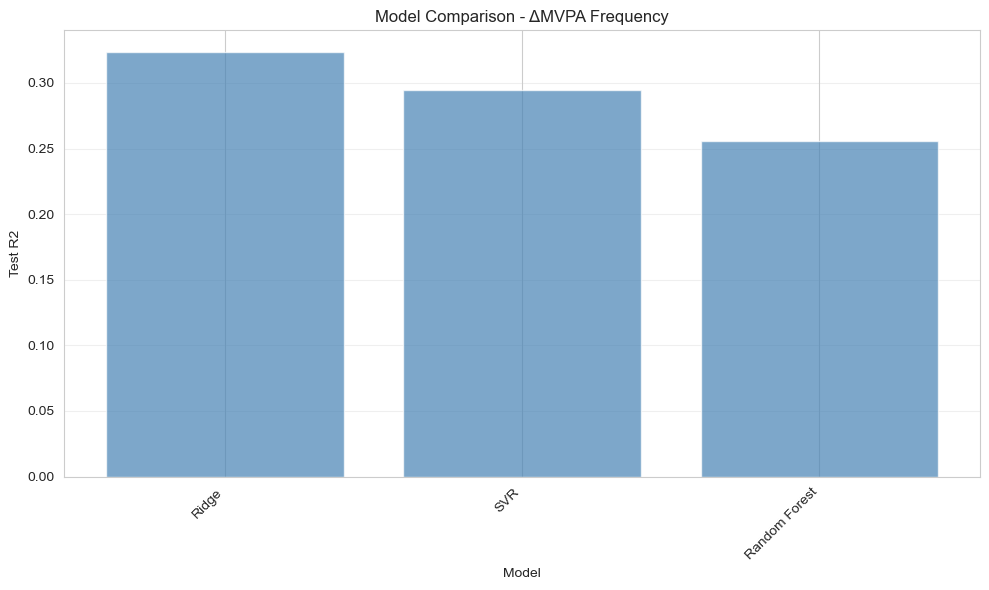

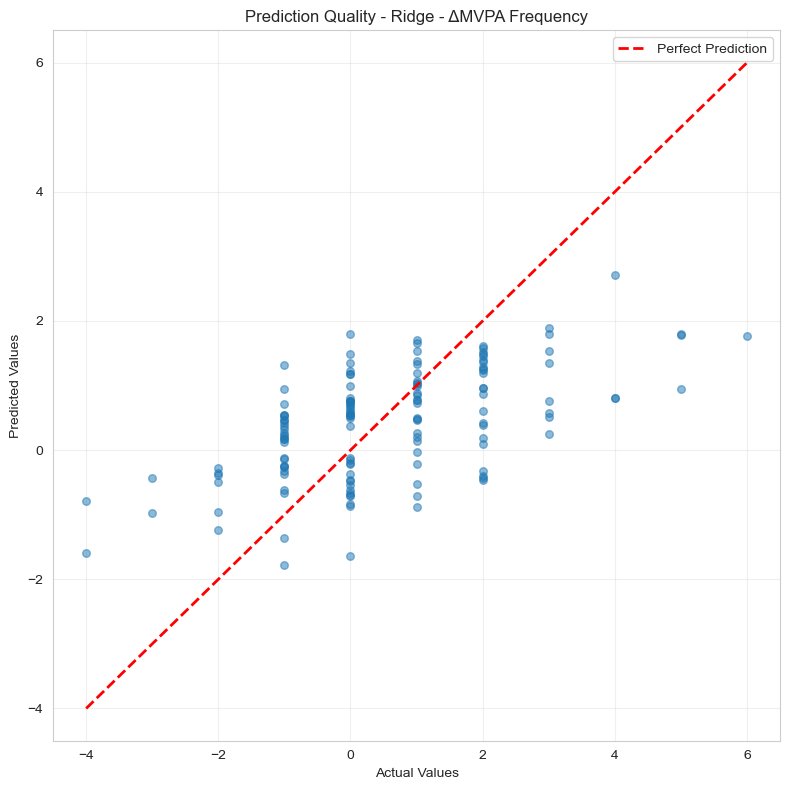

Ridge does not support feature importance extraction.


In [ ]:
# Visualize results
plot_model_comparison(test_results, target_variables[target])

# Plot predictions for best model
best_model_name = test_results.iloc[0]['Model']
plot_predictions(y_test, predictions[best_model_name], 
                best_model_name, target_variables[target])

# Feature importance
feature_importance = get_feature_importance(
    best_models[best_model_name], 
    baseline_features, 
    best_model_name, 
    target_variables[target]
)

# Store feature importance in results
mvpa_freq_results['feature_importance'] = feature_importance

if feature_importance is not None:
    print("\nTop 10 Most Important Features:")
    print(feature_importance.head(10).to_string(index=False))

### 7.2. Analysis: ΔMVPA Usual Week

Complete machine learning pipeline for predicting δmvpa usual week.

In [ ]:
# Prepare data
target = 'Delta_MVPA_Usual_Week'
X = data[baseline_features]
y = data[target]

# Remove missing values
valid_idx = ~(X.isna().any(axis=1) | y.isna())
X_clean = X[valid_idx]
y_clean = y[valid_idx]

print(f"Target: {target}")
print(f"Valid samples: {len(X_clean)} / {len(X)} ({100*len(X_clean)/len(X):.1f}%)")
print(f"Target mean: {y_clean.mean():.2f}, std: {y_clean.std():.2f}")

# Phase 1: Baseline training
cv_results, X_train, X_test, y_train, y_test, scaler = baseline_training(
    X_clean, y_clean, target_variables[target]
)

# Select top 3 models
top_3_models = cv_results.head(3)['Model'].tolist()

# Phase 2: Hyperparameter tuning
best_models, tuning_results = hyperparameter_tuning(
    X_train, y_train, top_3_models, target_variables[target]
)

# Phase 3: Final evaluation on test set
test_results, predictions = final_evaluation(
    best_models, X_test, y_test, target_variables[target]
)

# Store results
mvpa_week_results = {
    'cv_baseline': cv_results,
    'tuning': tuning_results,
    'test': test_results,
    'predictions': predictions,
    'best_models': best_models,
    'data': (X_train, X_test, y_train, y_test)
}

  Best CV R²: 0.1317
  Best params: {'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 5, 'n_estimators': 100}


Final Evaluation on Test Set: ΔMVPA Usual Week
Test set size: 140

Ridge                - R²: 0.3486 | MAE: 0.9960 | RMSE: 1.2476
SVR                  - R²: 0.2945 | MAE: 1.0201 | RMSE: 1.2984
Random Forest        - R²: 0.2018 | MAE: 1.0680 | RMSE: 1.3810

Best model on test set: Ridge
Test R²: 0.3486


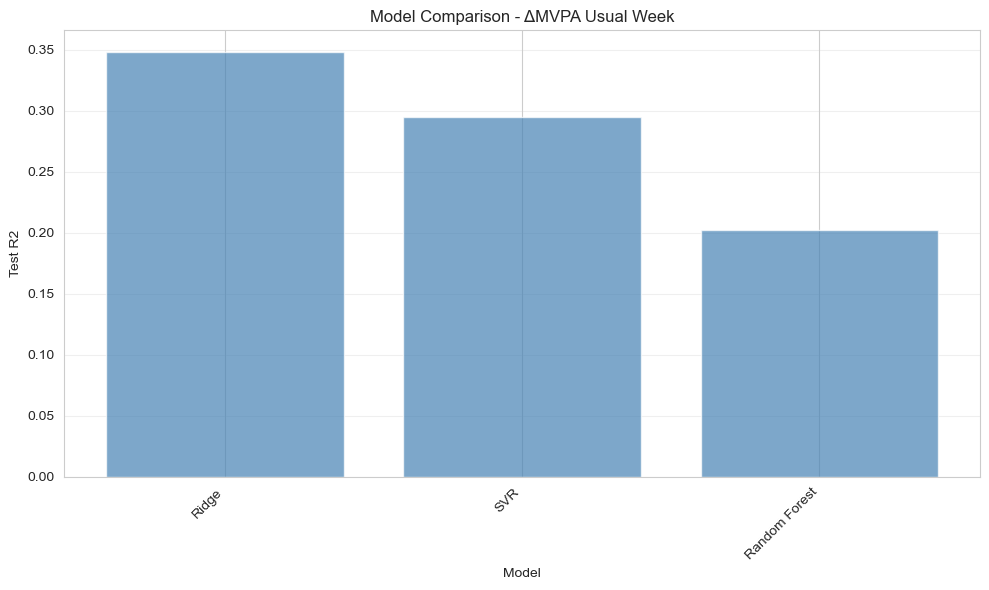

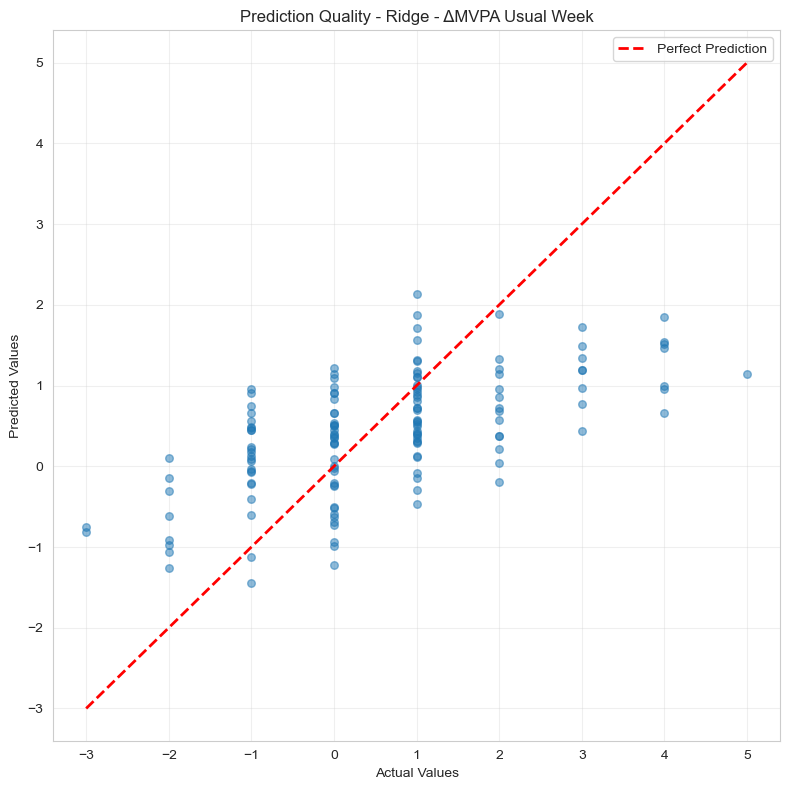

Ridge does not support feature importance extraction.


In [ ]:
# Visualize results
plot_model_comparison(test_results, target_variables[target])

# Plot predictions for best model
best_model_name = test_results.iloc[0]['Model']
plot_predictions(y_test, predictions[best_model_name], 
                best_model_name, target_variables[target])

# Feature importance
feature_importance = get_feature_importance(
    best_models[best_model_name], 
    baseline_features, 
    best_model_name, 
    target_variables[target]
)

# Store feature importance in results
mvpa_week_results['feature_importance'] = feature_importance

if feature_importance is not None:
    print("\nTop 10 Most Important Features:")
    print(feature_importance.head(10).to_string(index=False))

### 7.3. Analysis: ΔLeisure Exercise

Complete machine learning pipeline for predicting δleisure exercise.

In [ ]:
# Prepare data
target = 'Delta_Leisure_Exercise'
X = data[baseline_features]
y = data[target]

# Remove missing values
valid_idx = ~(X.isna().any(axis=1) | y.isna())
X_clean = X[valid_idx]
y_clean = y[valid_idx]

print(f"Target: {target}")
print(f"Valid samples: {len(X_clean)} / {len(X)} ({100*len(X_clean)/len(X):.1f}%)")
print(f"Target mean: {y_clean.mean():.2f}, std: {y_clean.std():.2f}")

# Phase 1: Baseline training
cv_results, X_train, X_test, y_train, y_test, scaler = baseline_training(
    X_clean, y_clean, target_variables[target]
)

# Select top 3 models
top_3_models = cv_results.head(3)['Model'].tolist()

# Phase 2: Hyperparameter tuning
best_models, tuning_results = hyperparameter_tuning(
    X_train, y_train, top_3_models, target_variables[target]
)

# Phase 3: Final evaluation on test set
test_results, predictions = final_evaluation(
    best_models, X_test, y_test, target_variables[target]
)

# Store results
leisure_ex_results = {
    'cv_baseline': cv_results,
    'tuning': tuning_results,
    'test': test_results,
    'predictions': predictions,
    'best_models': best_models,
    'data': (X_train, X_test, y_train, y_test)
}

Target: Delta_Leisure_Exercise
Valid samples: 697 / 697 (100.0%)
Target mean: 0.22, std: 1.46

Baseline Training: ΔLeisure Exercise
Training set size: 557 | Test set size: 140

Performing 5-fold cross-validation on training data...

Ridge                - CV R²: 0.3165 (+/- 0.1042)
Lasso                - CV R²: -0.0007 (+/- 0.0005)
ElasticNet           - CV R²: 0.1106 (+/- 0.0123)
Random Forest        - CV R²: 0.2578 (+/- 0.1575)
Gradient Boosting    - CV R²: 0.1895 (+/- 0.1826)
SVR                  - CV R²: 0.2598 (+/- 0.0450)
K-NN                 - CV R²: 0.0824 (+/- 0.0422)

Top 3 models selected for hyperparameter tuning:
  Ridge                - CV R²: 0.3165
  SVR                  - CV R²: 0.2598
  Random Forest        - CV R²: 0.2578

Hyperparameter Tuning: ΔLeisure Exercise
Tuning top 3 models using GridSearchCV with 5-fold CV...

Tuning Ridge...
  Best CV R²: 0.3184
  Best params: {'alpha': 10}

Tuning SVR...
  Best CV R²: 0.3092
  Best params: {'C': 100, 'epsilon': 0.1, 'gamm

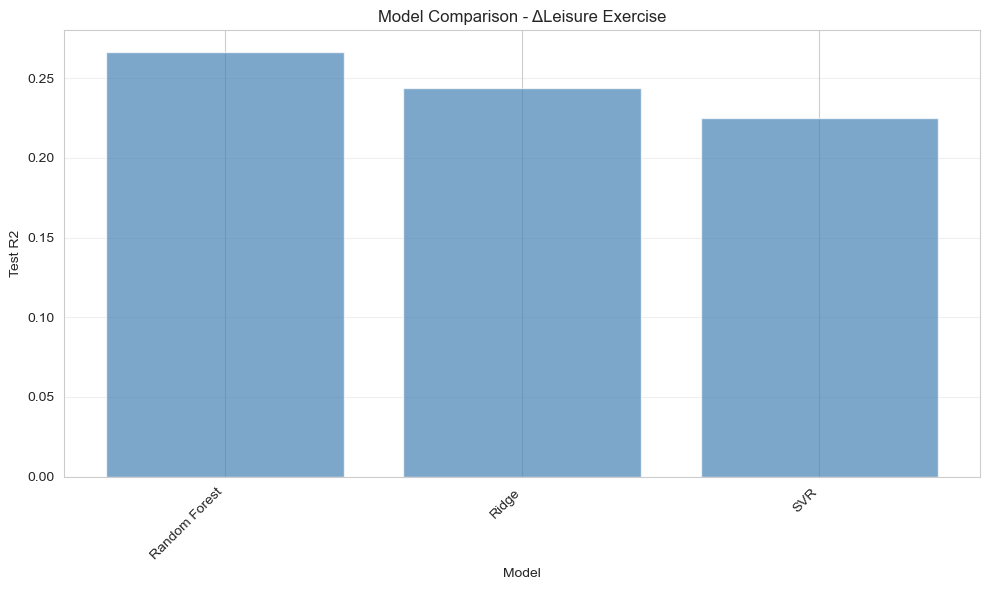

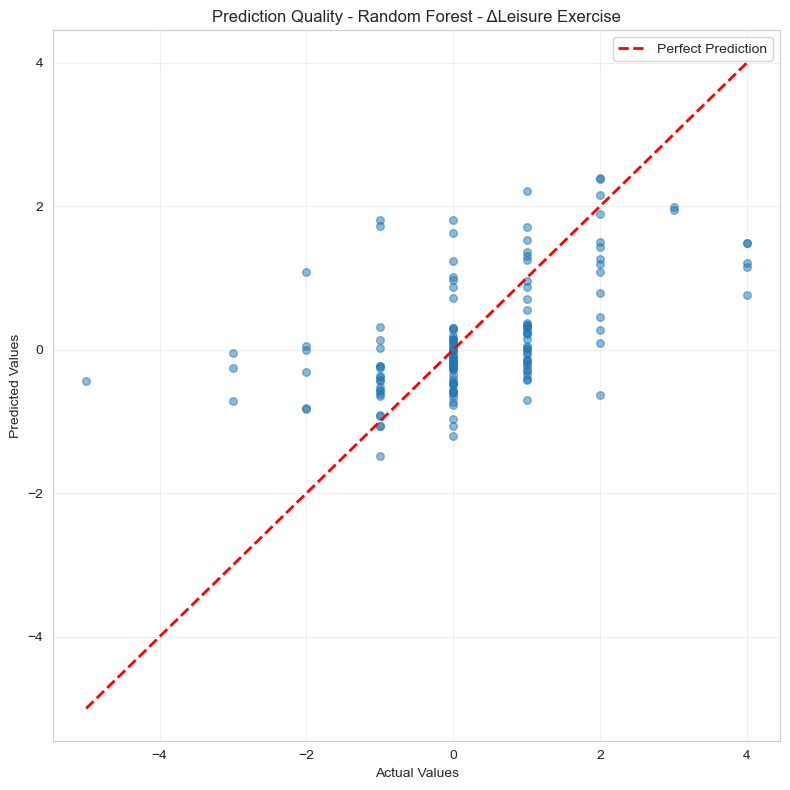

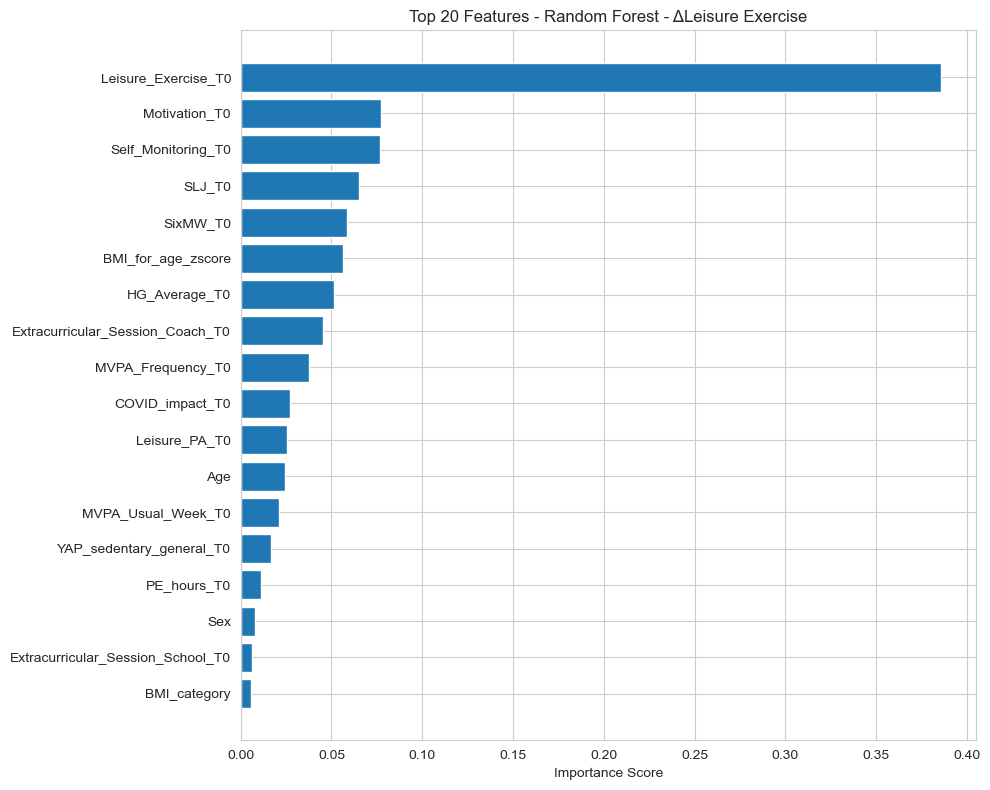


Top 10 Most Important Features:
                         Feature  Importance
             Leisure_Exercise_T0    0.385701
                   Motivation_T0    0.077313
              Self_Monitoring_T0    0.076595
                          SLJ_T0    0.065415
                        SixMW_T0    0.058724
              BMI_for_age_zscore    0.056226
                   HG_Average_T0    0.051394
Extracurricular_Session_Coach_T0    0.045141
               MVPA_Frequency_T0    0.037663
                 COVID_impact_T0    0.027245


In [ ]:
# Visualize results
plot_model_comparison(test_results, target_variables[target])

# Plot predictions for best model
best_model_name = test_results.iloc[0]['Model']
plot_predictions(y_test, predictions[best_model_name], 
                best_model_name, target_variables[target])

# Feature importance
feature_importance = get_feature_importance(
    best_models[best_model_name], 
    baseline_features, 
    best_model_name, 
    target_variables[target]
)

# Store feature importance in results
leisure_ex_results['feature_importance'] = feature_importance

if feature_importance is not None:
    print("\nTop 10 Most Important Features:")
    print(feature_importance.head(10).to_string(index=False))

### 7.4. Analysis: ΔLeisure PA

Complete machine learning pipeline for predicting δleisure pa.

In [ ]:
# Prepare data
target = 'Delta_Leisure_PA'
X = data[baseline_features]
y = data[target]

# Remove missing values
valid_idx = ~(X.isna().any(axis=1) | y.isna())
X_clean = X[valid_idx]
y_clean = y[valid_idx]

print(f"Target: {target}")
print(f"Valid samples: {len(X_clean)} / {len(X)} ({100*len(X_clean)/len(X):.1f}%)")
print(f"Target mean: {y_clean.mean():.2f}, std: {y_clean.std():.2f}")

# Phase 1: Baseline training
cv_results, X_train, X_test, y_train, y_test, scaler = baseline_training(
    X_clean, y_clean, target_variables[target]
)

# Select top 3 models
top_3_models = cv_results.head(3)['Model'].tolist()

# Phase 2: Hyperparameter tuning
best_models, tuning_results = hyperparameter_tuning(
    X_train, y_train, top_3_models, target_variables[target]
)

# Phase 3: Final evaluation on test set
test_results, predictions = final_evaluation(
    best_models, X_test, y_test, target_variables[target]
)

# Store results
leisure_pa_results = {
    'cv_baseline': cv_results,
    'tuning': tuning_results,
    'test': test_results,
    'predictions': predictions,
    'best_models': best_models,
    'data': (X_train, X_test, y_train, y_test)
}

Target: Delta_Leisure_PA
Valid samples: 697 / 697 (100.0%)
Target mean: 0.19, std: 0.94

Baseline Training: ΔLeisure PA
Training set size: 557 | Test set size: 140

Performing 5-fold cross-validation on training data...

Ridge                - CV R²: 0.2238 (+/- 0.0972)
Lasso                - CV R²: -0.0063 (+/- 0.0067)
ElasticNet           - CV R²: -0.0063 (+/- 0.0067)
Random Forest        - CV R²: 0.1384 (+/- 0.0944)
Gradient Boosting    - CV R²: 0.0664 (+/- 0.0679)
SVR                  - CV R²: 0.2203 (+/- 0.0859)
K-NN                 - CV R²: 0.0421 (+/- 0.0223)

Top 3 models selected for hyperparameter tuning:
  Ridge                - CV R²: 0.2238
  SVR                  - CV R²: 0.2203
  Random Forest        - CV R²: 0.1384

Hyperparameter Tuning: ΔLeisure PA
Tuning top 3 models using GridSearchCV with 5-fold CV...

Tuning Ridge...
  Best CV R²: 0.2253
  Best params: {'alpha': 10}

Tuning SVR...
  Best CV R²: 0.2513
  Best params: {'C': 100, 'epsilon': 0.2, 'gamma': 0.001}

Tunin

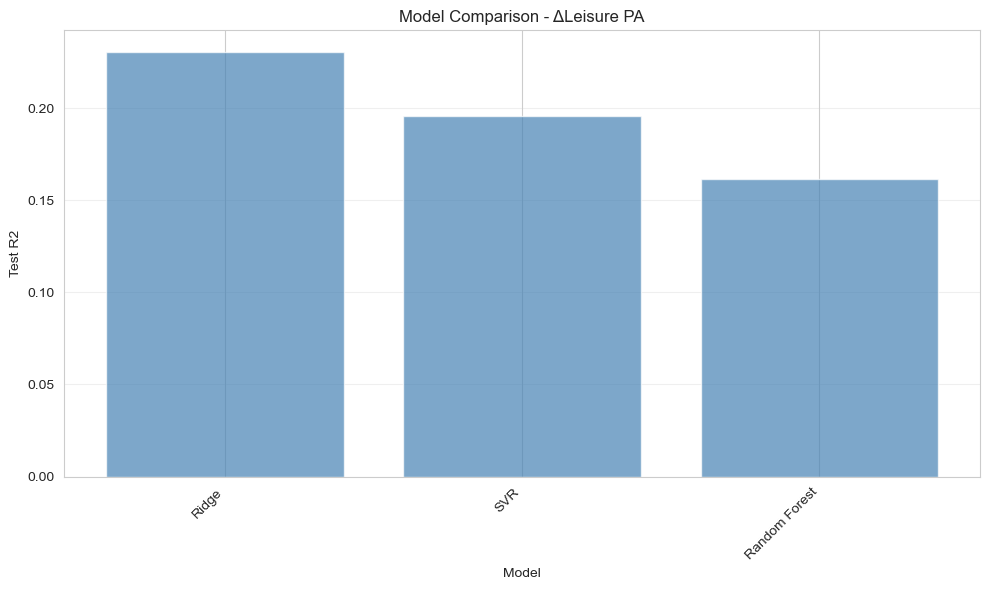

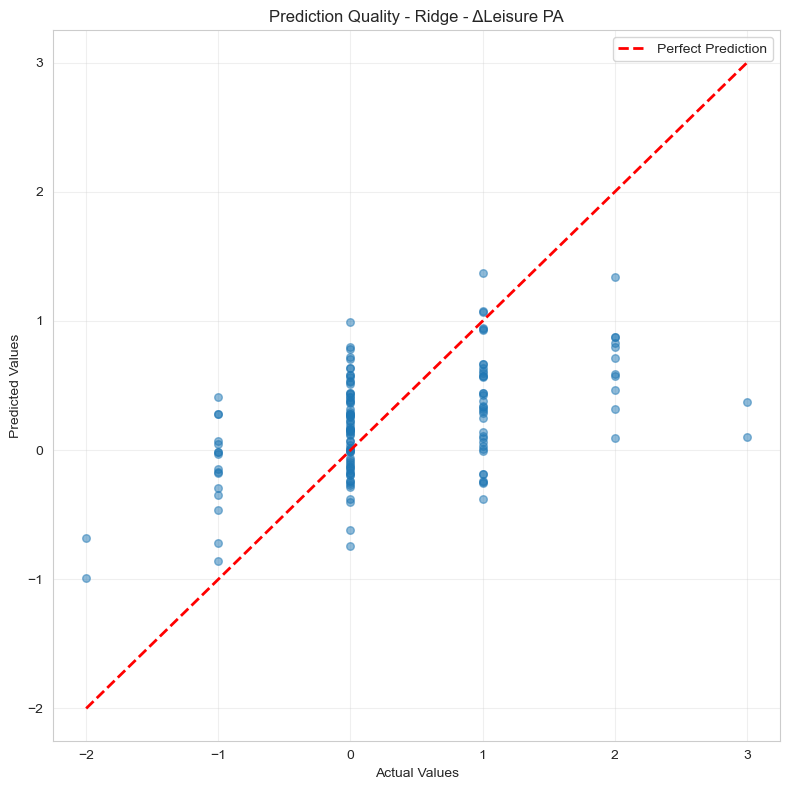

Ridge does not support feature importance extraction.


In [ ]:
# Visualize results
plot_model_comparison(test_results, target_variables[target])

# Plot predictions for best model
best_model_name = test_results.iloc[0]['Model']
plot_predictions(y_test, predictions[best_model_name], 
                best_model_name, target_variables[target])

# Feature importance
feature_importance = get_feature_importance(
    best_models[best_model_name], 
    baseline_features, 
    best_model_name, 
    target_variables[target]
)

# Store feature importance in results
leisure_pa_results['feature_importance'] = feature_importance

if feature_importance is not None:
    print("\nTop 10 Most Important Features:")
    print(feature_importance.head(10).to_string(index=False))

### 7.5. Summary Visualizations of Prediction Results

Visualizations summarizing the complete machine learning analysis.

In [ ]:
# Compile all results first
all_results_summary = {
    'ΔMVPA Frequency': leisure_ex_results,
    'ΔMVPA Usual Week': mvpa_week_results,
    'ΔLeisure Exercise': leisure_ex_results,
    'ΔLeisure PA': leisure_pa_results
}

print("Results compiled for visualization")

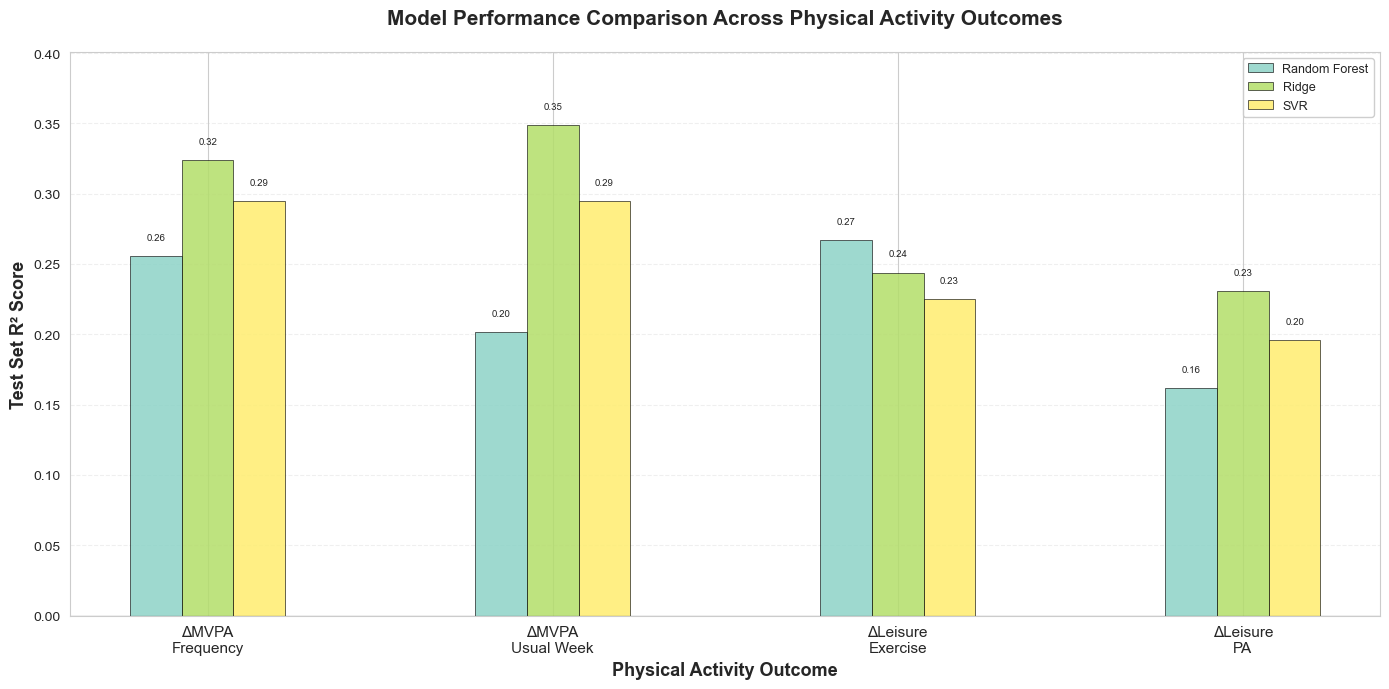

✓ Visualization 1: Model performance comparison created


In [ ]:
# VISUALIZATION 1: Model Performance Summary Across All Outcomes
# =============================================================================
# Professional bar chart comparing R² scores for all models and outcomes
# =============================================================================

fig, ax = plt.subplots(figsize=(14, 7))

# Prepare data
outcomes = ['ΔMVPA\nFrequency', 'ΔMVPA\nUsual Week', 'ΔLeisure\nExercise', 'ΔLeisure\nPA']
outcome_keys = list(target_variables.keys())

# Get all unique models tested
all_models_set = set()
for outcome_key in outcome_keys:
    results_dict = all_results[list(target_variables.values())[outcome_keys.index(outcome_key)]]
    for model_name in results_dict['test']['Model']:
        all_models_set.add(model_name)

all_models_list = sorted(list(all_models_set))

# Create data matrix
r2_matrix = []
for model_name in all_models_list:
    model_r2s = []
    for outcome_key in outcome_keys:
        results_dict = all_results[list(target_variables.values())[outcome_keys.index(outcome_key)]]
        test_df = results_dict['test']
        r2 = test_df[test_df['Model'] == model_name]['Test_R2'].values
        model_r2s.append(r2[0] if len(r2) > 0 else 0)
    r2_matrix.append(model_r2s)

# Plot grouped bars
x = np.arange(len(outcomes))
width = 0.15
colors = plt.cm.Set3(np.linspace(0, 1, len(all_models_list)))

for i, (model_name, color) in enumerate(zip(all_models_list, colors)):
    offset = width * (i - len(all_models_list)/2 + 0.5)
    bars = ax.bar(x + offset, r2_matrix[i], width, label=model_name, 
                   color=color, alpha=0.85, edgecolor='black', linewidth=0.5)
    
    # Add value labels on bars
    for j, (bar, val) in enumerate(zip(bars, r2_matrix[i])):
        if val > 0.05:  # Only show label if bar is visible
            ax.text(bar.get_x() + bar.get_width()/2, val + 0.01, 
                   f'{val:.2f}', ha='center', va='bottom', fontsize=7, rotation=0)

ax.set_xlabel('Physical Activity Outcome', fontsize=13, fontweight='bold')
ax.set_ylabel('Test Set R² Score', fontsize=13, fontweight='bold')
ax.set_title('Model Performance Comparison Across Physical Activity Outcomes', 
             fontsize=15, fontweight='bold', pad=20)
ax.set_xticks(x)
ax.set_xticklabels(outcomes, fontsize=11)
ax.legend(loc='upper right', framealpha=0.95, fontsize=9)
ax.grid(axis='y', alpha=0.3, linestyle='--')
ax.set_ylim(0, max([max(row) for row in r2_matrix]) * 1.15)

# Add horizontal line at R²=0
ax.axhline(y=0, color='black', linewidth=0.8)

plt.tight_layout()
plt.show()

print("✓ Visualization 1: Model performance comparison created")

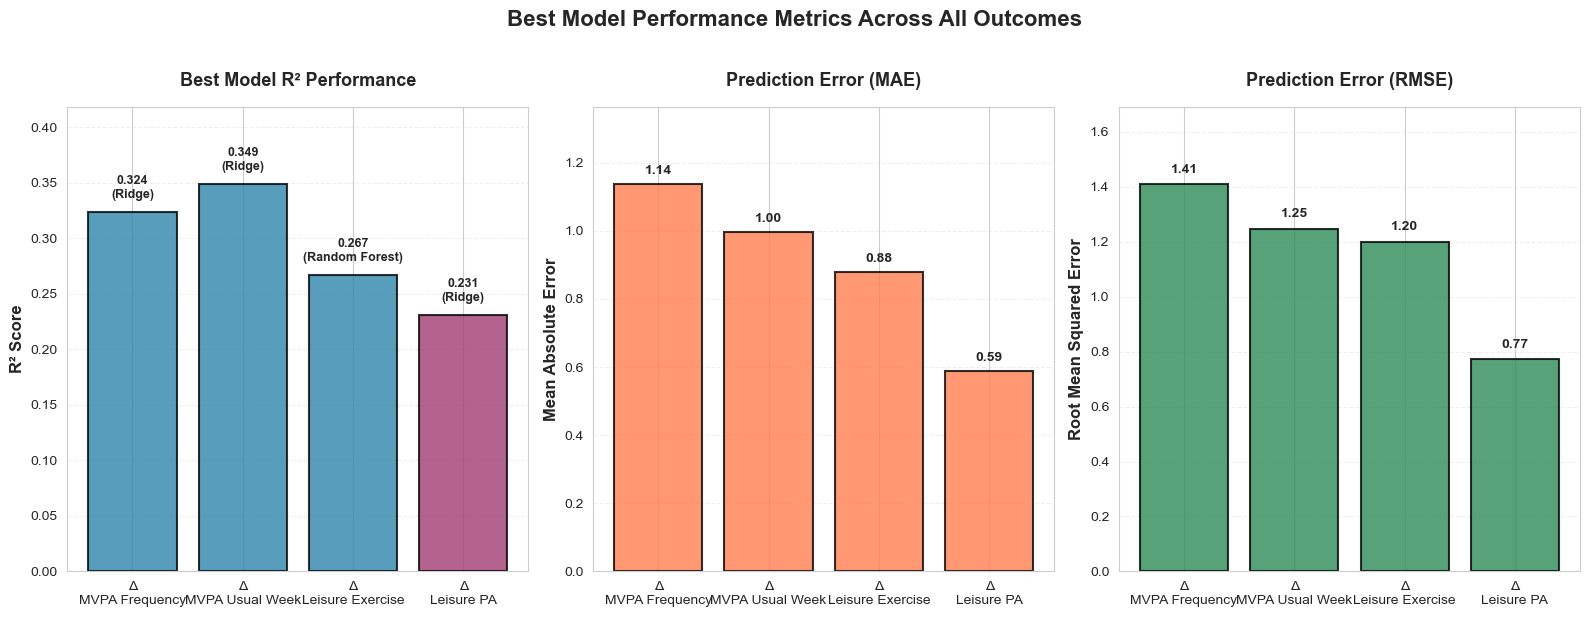

✓ Visualization 2: Best model performance metrics created


In [ ]:
# VISUALIZATION 2: Best Model Performance Summary
# =============================================================================
# Clean summary showing only the best model for each outcome
# =============================================================================

fig, axes = plt.subplots(1, 3, figsize=(16, 6))

# Prepare best model data
best_models_data = []
for outcome_key, outcome_name in target_variables.items():
    results_dict = all_results[outcome_name]
    best_row = results_dict['test'].iloc[0]
    best_models_data.append({
        'Outcome': outcome_name,
        'Model': best_row['Model'],
        'R2': best_row['Test_R2'],
        'MAE': best_row['Test_MAE'],
        'RMSE': best_row['Test_RMSE']
    })

best_df = pd.DataFrame(best_models_data)
outcomes_short = [o.replace('Δ', 'Δ\n') for o in best_df['Outcome']]

# Plot 1: R² scores
colors_r2 = ['#2E86AB' if r2 > 0.25 else '#A23B72' for r2 in best_df['R2']]
bars1 = axes[0].bar(range(len(best_df)), best_df['R2'], color=colors_r2, 
                     alpha=0.8, edgecolor='black', linewidth=1.5)
axes[0].set_xticks(range(len(best_df)))
axes[0].set_xticklabels(outcomes_short, fontsize=10)
axes[0].set_ylabel('R² Score', fontsize=12, fontweight='bold')
axes[0].set_title('Best Model R² Performance', fontsize=13, fontweight='bold', pad=15)
axes[0].grid(axis='y', alpha=0.3, linestyle='--')
axes[0].set_ylim(0, max(best_df['R2']) * 1.2)

# Add value labels and model names
for i, (bar, row) in enumerate(zip(bars1, best_df.iterrows())):
    axes[0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                f"{row[1]['R2']:.3f}\n({row[1]['Model']})", 
                ha='center', va='bottom', fontsize=9, fontweight='bold')

# Plot 2: MAE scores
bars2 = axes[1].bar(range(len(best_df)), best_df['MAE'], color='coral', 
                     alpha=0.8, edgecolor='black', linewidth=1.5)
axes[1].set_xticks(range(len(best_df)))
axes[1].set_xticklabels(outcomes_short, fontsize=10)
axes[1].set_ylabel('Mean Absolute Error', fontsize=12, fontweight='bold')
axes[1].set_title('Prediction Error (MAE)', fontsize=13, fontweight='bold', pad=15)
axes[1].grid(axis='y', alpha=0.3, linestyle='--')
axes[1].set_ylim(0, max(best_df['MAE']) * 1.2)

# Add value labels
for bar, val in zip(bars2, best_df['MAE']):
    axes[1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02,
                f'{val:.2f}', ha='center', va='bottom', fontsize=10, fontweight='bold')

# Plot 3: RMSE scores  
bars3 = axes[2].bar(range(len(best_df)), best_df['RMSE'], color='seagreen', 
                     alpha=0.8, edgecolor='black', linewidth=1.5)
axes[2].set_xticks(range(len(best_df)))
axes[2].set_xticklabels(outcomes_short, fontsize=10)
axes[2].set_ylabel('Root Mean Squared Error', fontsize=12, fontweight='bold')
axes[2].set_title('Prediction Error (RMSE)', fontsize=13, fontweight='bold', pad=15)
axes[2].grid(axis='y', alpha=0.3, linestyle='--')
axes[2].set_ylim(0, max(best_df['RMSE']) * 1.2)

# Add value labels
for bar, val in zip(bars3, best_df['RMSE']):
    axes[2].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.03,
                f'{val:.2f}', ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.suptitle('Best Model Performance Metrics Across All Outcomes', 
             fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

print("✓ Visualization 2: Best model performance metrics created")

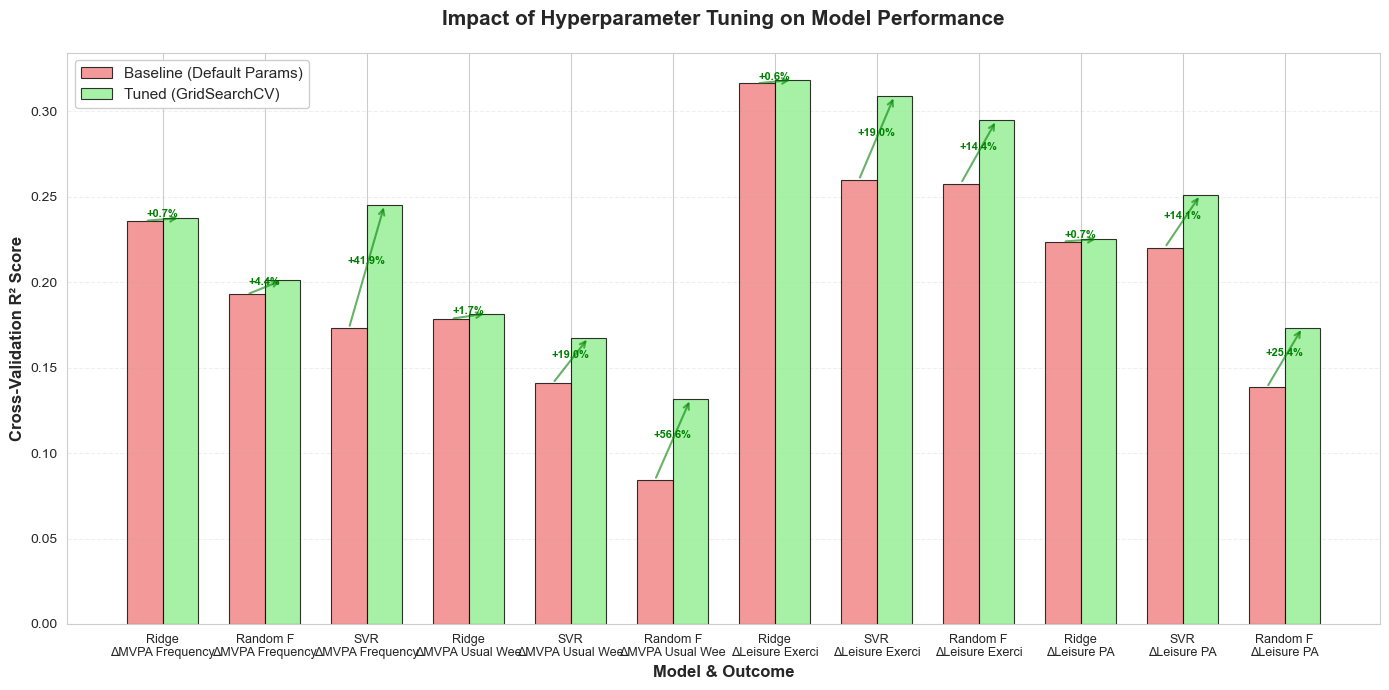

✓ Visualization 4: Baseline vs tuned performance created
  Average improvement: 0.0263 R² points


In [ ]:
# VISUALIZATION 4: Baseline vs Tuned Model Performance
# =============================================================================
# Show the improvement from baseline to tuned models
# =============================================================================

fig, ax = plt.subplots(figsize=(14, 7))

# Get baseline and tuned performance for each outcome
improvement_data = []

for outcome_key, outcome_name in target_variables.items():
    results_dict = all_results[outcome_name]
    
    # Get top 3 models from baseline
    baseline_df = results_dict['cv_baseline'].head(3)
    tuning_df = results_dict['tuning']
    
    for model_name in baseline_df['Model']:
        baseline_r2 = baseline_df[baseline_df['Model'] == model_name]['CV_R2_Mean'].values[0]
        tuned_r2 = tuning_df[tuning_df['Model'] == model_name]['Best_CV_R2'].values
        
        if len(tuned_r2) > 0:
            improvement_data.append({
                'Outcome': outcome_name,
                'Model': model_name,
                'Baseline_R2': baseline_r2,
                'Tuned_R2': tuned_r2[0],
                'Improvement': tuned_r2[0] - baseline_r2
            })

improvement_df = pd.DataFrame(improvement_data)

# Plot grouped bars for each outcome
outcomes_list = list(target_variables.values())
x = np.arange(len(improvement_df))
width = 0.35

# Group by outcome
bars1 = ax.bar(x - width/2, improvement_df['Baseline_R2'], width, 
               label='Baseline (Default Params)', color='lightcoral', 
               alpha=0.8, edgecolor='black', linewidth=0.8)
bars2 = ax.bar(x + width/2, improvement_df['Tuned_R2'], width,
               label='Tuned (GridSearchCV)', color='lightgreen', 
               alpha=0.8, edgecolor='black', linewidth=0.8)

# Add improvement arrows
for i, (idx, row) in enumerate(improvement_df.iterrows()):
    if row['Improvement'] > 0:
        ax.annotate('', xy=(i + width/2, row['Tuned_R2']), 
                   xytext=(i - width/2, row['Baseline_R2']),
                   arrowprops=dict(arrowstyle='->', lw=1.5, color='green', alpha=0.6))
        # Add improvement percentage
        mid_y = (row['Baseline_R2'] + row['Tuned_R2']) / 2
        improvement_pct = (row['Improvement'] / row['Baseline_R2']) * 100
        ax.text(i, mid_y, f'+{improvement_pct:.1f}%', ha='center', va='bottom',
               fontsize=8, color='green', fontweight='bold', rotation=0)

ax.set_xlabel('Model & Outcome', fontsize=12, fontweight='bold')
ax.set_ylabel('Cross-Validation R² Score', fontsize=12, fontweight='bold')
ax.set_title('Impact of Hyperparameter Tuning on Model Performance', 
             fontsize=15, fontweight='bold', pad=20)
ax.set_xticks(x)
ax.set_xticklabels([f"{row['Model'][:8]}\n{row['Outcome'][:15]}" 
                    for idx, row in improvement_df.iterrows()], 
                   fontsize=9, rotation=0)
ax.legend(loc='upper left', fontsize=11, framealpha=0.95)
ax.grid(axis='y', alpha=0.3, linestyle='--')

plt.tight_layout()
plt.show()

print("✓ Visualization 4: Baseline vs tuned performance created")
print(f"  Average improvement: {improvement_df['Improvement'].mean():.4f} R² points")

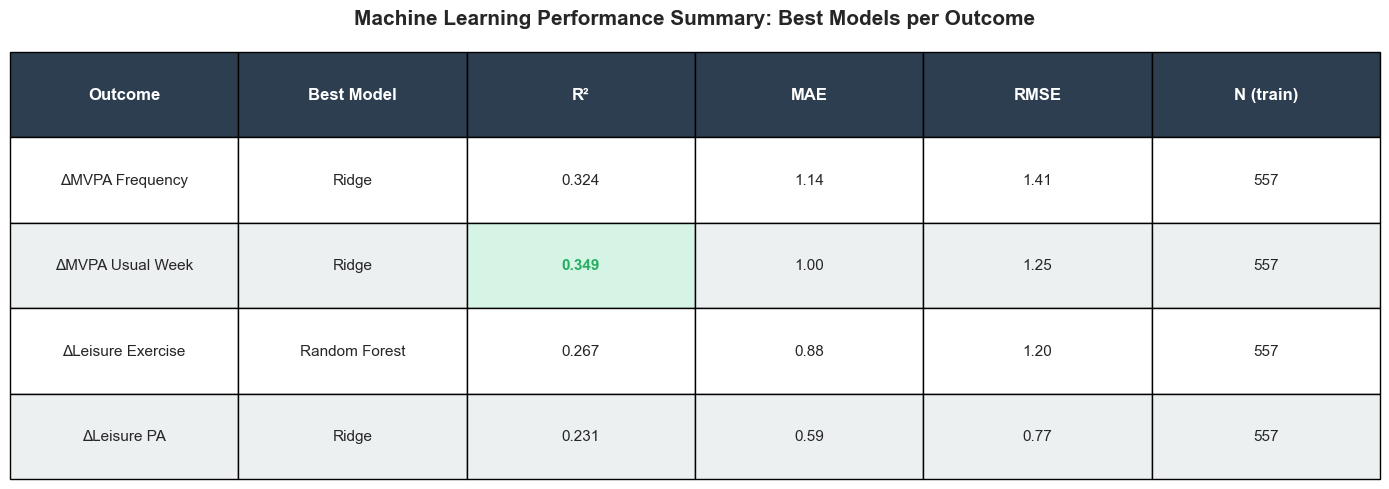

✓ Visualization 5: Summary table created


In [ ]:
# VISUALIZATION 5: Performance Summary Table (Publication Style)
# =============================================================================
# Clean, professional table summarizing all key results
# =============================================================================

fig, ax = plt.subplots(figsize=(14, 5))
ax.axis('tight')
ax.axis('off')

# Prepare table data
table_data = []
for outcome_key, outcome_name in target_variables.items():
    results_dict = all_results[outcome_name]
    best_row = results_dict['test'].iloc[0]
    
    table_data.append([
        outcome_name,
        best_row['Model'],
        f"{best_row['Test_R2']:.3f}",
        f"{best_row['Test_MAE']:.2f}",
        f"{best_row['Test_RMSE']:.2f}",
        f"{len(results_dict['data'][2])}"  # Training set size
    ])

# Create table
columns = ['Outcome', 'Best Model', 'R²', 'MAE', 'RMSE', 'N (train)']
table = ax.table(cellText=table_data, colLabels=columns, cellLoc='center',
                loc='center', bbox=[0, 0, 1, 1])

# Style the table
table.auto_set_font_size(False)
table.set_fontsize(11)
table.scale(1, 2.5)

# Header styling
for i in range(len(columns)):
    cell = table[(0, i)]
    cell.set_facecolor('#2C3E50')
    cell.set_text_props(weight='bold', color='white', fontsize=12)

# Row styling (alternating colors)
for i in range(1, len(table_data) + 1):
    for j in range(len(columns)):
        cell = table[(i, j)]
        if i % 2 == 0:
            cell.set_facecolor('#ECF0F1')
        else:
            cell.set_facecolor('white')
        
        # Highlight best R² in green
        if j == 2:  # R² column
            r2_val = float(table_data[i-1][2])
            if r2_val == max([float(row[2]) for row in table_data]):
                cell.set_facecolor('#D5F4E6')
                cell.set_text_props(weight='bold', color='#27AE60')

plt.title('Machine Learning Performance Summary: Best Models per Outcome', 
          fontsize=15, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

print("✓ Visualization 5: Summary table created")

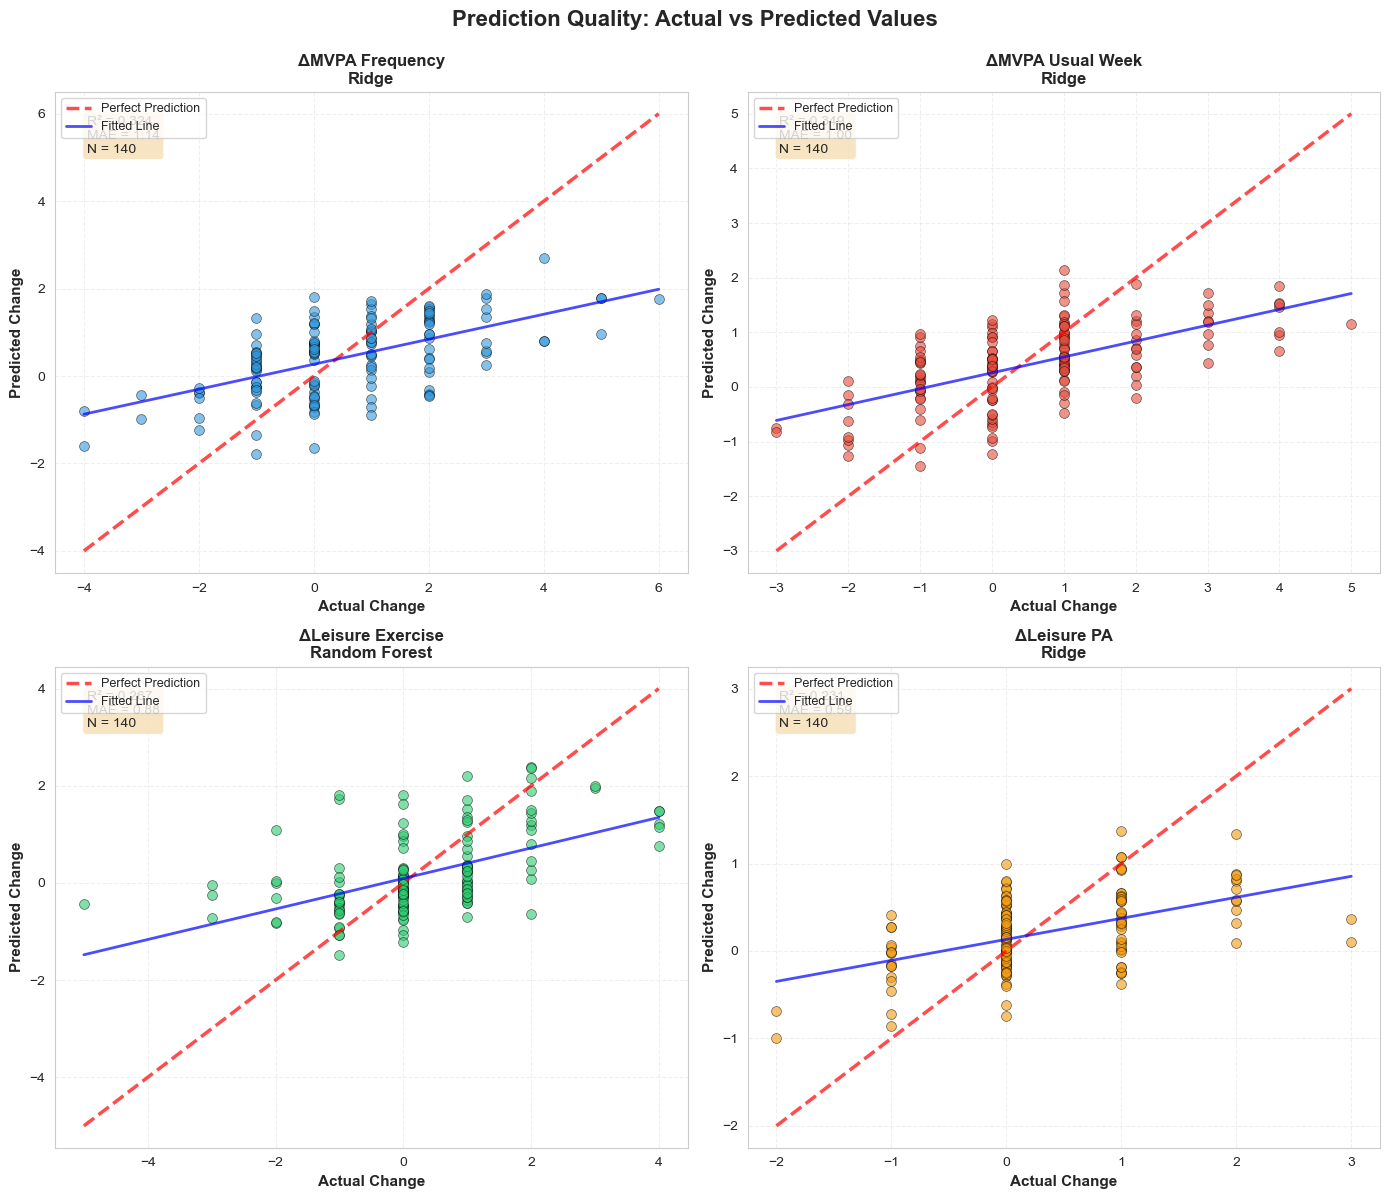

✓ Visualization 6: Actual vs predicted scatter plots created


In [ ]:
# VISUALIZATION 6: Actual vs Predicted Values (Combined)
# =============================================================================
# 2x2 grid showing prediction quality for all outcomes
# =============================================================================

fig, axes = plt.subplots(2, 2, figsize=(14, 12))
axes = axes.flatten()

colors_outcomes = ['#3498db', '#e74c3c', '#2ecc71', '#f39c12']

for idx, (outcome_key, outcome_name) in enumerate(target_variables.items()):
    results_dict = all_results[outcome_name]
    best_model_name = results_dict['test'].iloc[0]['Model']
    
    # Get predictions
    _, _, _, y_test = results_dict['data']
    y_pred = results_dict['predictions'][best_model_name]
    
    # Calculate metrics
    r2 = r2_score(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    
    # Scatter plot
    ax = axes[idx]
    ax.scatter(y_test, y_pred, alpha=0.6, s=50, color=colors_outcomes[idx], 
              edgecolor='black', linewidth=0.5)
    
    # Perfect prediction line
    min_val = min(y_test.min(), y_pred.min())
    max_val = max(y_test.max(), y_pred.max())
    ax.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2.5, 
           label='Perfect Prediction', alpha=0.7)
    
    # Add regression line
    z = np.polyfit(y_test, y_pred, 1)
    p = np.poly1d(z)
    ax.plot([min_val, max_val], p([min_val, max_val]), 'b-', lw=2, 
           label='Fitted Line', alpha=0.7)
    
    ax.set_xlabel('Actual Change', fontsize=11, fontweight='bold')
    ax.set_ylabel('Predicted Change', fontsize=11, fontweight='bold')
    ax.set_title(f'{outcome_name}\n{best_model_name}', 
                fontsize=12, fontweight='bold')
    ax.legend(loc='best', fontsize=9)
    ax.grid(alpha=0.3, linestyle='--')
    
    # Add text box with metrics
    textstr = f'R² = {r2:.3f}\nMAE = {mae:.2f}\nN = {len(y_test)}'
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.8)
    ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=10,
           verticalalignment='top', bbox=props)

plt.suptitle('Prediction Quality: Actual vs Predicted Values', 
             fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

print("✓ Visualization 6: Actual vs predicted scatter plots created")

## 8. Analysis of Feature Importance

### 8.1. Cross-Target Feature Importance Analysis

In [ ]:
# Feature Importance Analysis: Use Best Tree-Based Model for Each Outcome
# =============================================================================
# Strategy: For each outcome, use the best-performing tree-based model
# (Random Forest or Gradient Boosting) to extract feature importance rankings,
# even if the overall best model is linear (Ridge/Lasso/ElasticNet)
# =============================================================================

importance_data = {}

print("="*80)
print("FEATURE IMPORTANCE RANKINGS - BEST TREE-BASED MODELS")
print("="*80)
print("\nNote: Using best tree-based model (RF/GB) for feature importance,")
print("      even if linear models achieved better overall performance.\n")

for target_name, results in all_results.items():
    # Strategy: Find the best tree-based model among those we tuned
    best_tree_model = None
    best_tree_name = None
    best_cv_r2 = -np.inf
    
    # Check tuned models first (these are the top 3 performers)
    for model_name, model in results['best_models'].items():
        if model_name in ['Random Forest', 'Gradient Boosting']:
            # Get the CV R² from tuning results
            cv_r2 = results['tuning'][results['tuning']['Model'] == model_name]['Best_CV_R2'].values[0]
            if cv_r2 > best_cv_r2:
                best_cv_r2 = cv_r2
                best_tree_name = model_name
                best_tree_model = model
    
    # If no tree-based model in top 3, train one specifically for feature importance
    if best_tree_model is None:
        print(f"\n{target_name}:")
        print("  No tree-based model in top 3 performers.")
        print("  Training Random Forest specifically for feature importance...")
        
        # Get the data for this target
        X_train, X_test, y_train, y_test = results['data']
        
        # Train a Random Forest for feature importance
        rf_for_importance = RandomForestRegressor(
            n_estimators=200,
            max_depth=10,
            min_samples_split=5,
            random_state=42,
            n_jobs=-1
        )
        rf_for_importance.fit(X_train, y_train)
        
        # Evaluate it
        y_pred = rf_for_importance.predict(X_test)
        rf_r2 = r2_score(y_test, y_pred)
        
        best_tree_model = rf_for_importance
        best_tree_name = 'Random Forest (for importance)'
        best_cv_r2 = rf_r2
        
        print(f"  → Trained RF achieved Test R² = {rf_r2:.4f}")
    
    # Extract feature importance
    if best_tree_model is not None:
        # Get complete feature importance ranking
        importance_df = pd.DataFrame({
            'Feature': baseline_features,
            'Importance': best_tree_model.feature_importances_
        }).sort_values('Importance', ascending=False).reset_index(drop=True)
        
        # Add ranking
        importance_df.insert(0, 'Rank', range(1, len(importance_df) + 1))
        
        # Calculate cumulative importance
        importance_df['Cumulative_Importance'] = importance_df['Importance'].cumsum()
        
        # Store results
        importance_data[target_name] = {
            'df': importance_df,
            'model_name': best_tree_name,
            'r2': best_cv_r2
        }
        
        # Get overall best model info for comparison
        best_overall = results['test'].iloc[0]
        
        print(f"\n{target_name}:")
        print(f"  Best Overall Model: {best_overall['Model']} (Test R² = {best_overall['Test_R2']:.4f})")
        print(f"  Feature Importance From: {best_tree_name} (R² = {best_cv_r2:.4f})")
        print("-" * 80)
        print("\nCOMPLETE FEATURE RANKING:")
        
        # Display with better formatting
        display_df = importance_df.copy()
        display_df['Importance'] = display_df['Importance'].apply(lambda x: f"{x:.4f}")
        display_df['Cumulative_Importance'] = display_df['Cumulative_Importance'].apply(lambda x: f"{x:.4f}")
        print(display_df.to_string(index=False))
        
        # Highlight top features (80% cumulative importance)
        top_features = importance_df[importance_df['Cumulative_Importance'] <= 0.80]
        print(f"\n  → Top {len(top_features)} features explain 80% of variance")
        print()

print("\n" + "="*80)
print("FEATURE IMPORTANCE EXTRACTION COMPLETE")
print("="*80)
print(f"Successfully extracted feature rankings for {len(importance_data)}/{len(all_results)} outcomes")
print("="*80)

# Summary: Feature Importance Across All Outcomes
# =============================================================================
# Synthesize feature rankings across all four physical activity outcomes
# to identify consistently important predictors
# =============================================================================

print("\n" + "="*80)
print("CROSS-OUTCOME FEATURE IMPORTANCE SUMMARY")
print("="*80)

if len(importance_data) > 0:
    # Create a combined ranking showing each feature's rank in each outcome
    all_feature_ranks = {}
    
    for outcome, data_dict in importance_data.items():
        df = data_dict['df']
        for idx, row in df.iterrows():
            feature = row['Feature']
            rank = row['Rank']
            importance = row['Importance']
            
            if feature not in all_feature_ranks:
                all_feature_ranks[feature] = {
                    'ranks': {},
                    'importances': {}
                }
            
            all_feature_ranks[feature]['ranks'][outcome] = rank
            all_feature_ranks[feature]['importances'][outcome] = importance
    
    # Calculate average rank and importance for each feature
    feature_summary = []
    for feature, data in all_feature_ranks.items():
        ranks = list(data['ranks'].values())
        importances = list(data['importances'].values())
        
        feature_summary.append({
            'Feature': feature,
            'Avg_Rank': np.mean(ranks),
            'Best_Rank': min(ranks),
            'Avg_Importance': np.mean(importances),
            'N_Outcomes_Top10': sum(1 for r in ranks if r <= 10),
            'N_Outcomes_Top5': sum(1 for r in ranks if r <= 5),
        })
    
    # Sort by average rank
    summary_df = pd.DataFrame(feature_summary).sort_values('Avg_Rank')
    
    # Display top 20 features
    print("\nTOP 20 FEATURES BY AVERAGE RANK:")
    print("-" * 80)
    display_cols = ['Feature', 'Avg_Rank', 'Best_Rank', 'Avg_Importance', 
                    'N_Outcomes_Top10', 'N_Outcomes_Top5']
    top_20 = summary_df.head(20)[display_cols].copy()
    top_20['Avg_Rank'] = top_20['Avg_Rank'].apply(lambda x: f"{x:.1f}")
    top_20['Avg_Importance'] = top_20['Avg_Importance'].apply(lambda x: f"{x:.4f}")
    print(top_20.to_string(index=False))
    
    # Features consistently in top 10
    print("\n" + "="*80)
    print("CONSISTENTLY IMPORTANT FEATURES (TOP 10 IN MULTIPLE OUTCOMES)")
    print("="*80)
    
    consistent_top10 = summary_df[summary_df['N_Outcomes_Top10'] >= 2].sort_values(
        'N_Outcomes_Top10', ascending=False
    )
    
    if len(consistent_top10) > 0:
        print(f"\nFound {len(consistent_top10)} features that rank in top 10 for 2+ outcomes:")
        print("-" * 80)
        display_consistent = consistent_top10[display_cols].copy()
        display_consistent['Avg_Rank'] = display_consistent['Avg_Rank'].apply(lambda x: f"{x:.1f}")
        display_consistent['Avg_Importance'] = display_consistent['Avg_Importance'].apply(lambda x: f"{x:.4f}")
        print(display_consistent.to_string(index=False))
    else:
        print("\nNo features appear in top 10 for multiple outcomes.")
    
    # Detailed breakdown by outcome
    print("\n" + "="*80)
    print("FEATURE RANKS BY OUTCOME")
    print("="*80)
    
    # Create a detailed table
    detailed_ranks = []
    for feature, data in all_feature_ranks.items():
        row = {'Feature': feature}
        for outcome in importance_data.keys():
            short_outcome = outcome.replace('Δ', 'D').replace(' ', '_')[:15]
            row[short_outcome] = data['ranks'].get(outcome, '-')
        row['Avg'] = np.mean(list(data['ranks'].values()))
        detailed_ranks.append(row)
    
    detailed_df = pd.DataFrame(detailed_ranks).sort_values('Avg')
    
    print("\nTop 15 features with ranks across all outcomes:")
    print("-" * 80)
    display_detailed = detailed_df.head(15).copy()
    display_detailed['Avg'] = display_detailed['Avg'].apply(lambda x: f"{x:.1f}")
    print(display_detailed.to_string(index=False))
    
    # Feature categories analysis
    print("\n" + "="*80)
    print("FEATURE IMPORTANCE BY CATEGORY")
    print("="*80)
    
    # Categorize features
    def categorize_feature(feat):
        """
        Categorize features into meaningful groups for PE4MOVE study.
        
        Categories based on Self-Determination Theory and intervention design:
        - Demographic/Anthropometric: Age, Sex, BMI measures
        - Baseline Physical Activity: MVPA, Leisure Exercise/PA, Sedentary behavior
        - Fitness/Motor Competence: 6-minute walk, standing long jump, handgrip
        - Psychosocial: Motivation, Self-monitoring
        - Contextual/Environmental: PE hours, extracurricular sessions, COVID impact
        """
        
        # Demographic and Anthropometric
        if feat in ['Age', 'Sex', 'BMI_for_age_zscore', 'BMI_category']:
            return 'Demographic/Anthropometric'
        
        # Baseline Physical Activity (all T0 PA measurements)
        elif feat in ['MVPA_Frequency_T0', 'MVPA_Usual_Week_T0', 
                    'Leisure_Exercise_T0', 'Leisure_PA_T0', 
                    'YAP_sedentary_general_T0']:
            return 'Baseline Physical Activity'
        
        # Fitness and Motor Competence (physical tests)
        elif feat in ['SixMW_T0', 'SLJ_T0', 'HG_Average_T0']:
            return 'Fitness/Motor Competence'
        
        # Psychosocial factors (motivation, self-regulation)
        elif feat in ['Motivation_T0', 'Self_Monitoring_T0']:
            return 'Psychosocial'
        
        # Contextual and Environmental factors
        elif feat in ['PE_hours_T0', 'Extracurricular_Session_Coach_T0', 
                    'Extracurricular_Session_School_T0', 'COVID_impact_T0']:
            return 'Contextual/Environmental'
        
        # Catch any unexpected features
        else:
            return 'Other'
    
    summary_df['Category'] = summary_df['Feature'].apply(categorize_feature)
    category_importance = summary_df.groupby('Category').agg({
        'Avg_Rank': 'mean',
        'Avg_Importance': 'mean',
        'Feature': 'count'
    }).rename(columns={'Feature': 'N_Features'}).sort_values('Avg_Rank')
    
    print("\nAverage importance by feature category:")
    print("-" * 80)
    cat_display = category_importance.copy()
    cat_display['Avg_Rank'] = cat_display['Avg_Rank'].apply(lambda x: f"{x:.1f}")
    cat_display['Avg_Importance'] = cat_display['Avg_Importance'].apply(lambda x: f"{x:.4f}")
    print(cat_display.to_string())
    
else:
    print("\nNo feature importance data available.")

print("\n" + "="*80)

FEATURE IMPORTANCE RANKINGS - BEST TREE-BASED MODELS

Note: Using best tree-based model (RF/GB) for feature importance,
      even if linear models achieved better overall performance.


ΔMVPA Frequency:
  Best Overall Model: Ridge (Test R² = 0.3239)
  Feature Importance From: Random Forest (R² = 0.2013)
--------------------------------------------------------------------------------

COMPLETE FEATURE RANKING:
 Rank                           Feature Importance Cumulative_Importance
    1                 MVPA_Frequency_T0     0.2706                0.2706
    2                BMI_for_age_zscore     0.1026                0.3732
    3                          SixMW_T0     0.0792                0.4524
    4                            SLJ_T0     0.0737                0.5261
    5                     Motivation_T0     0.0636                0.5897
    6                     HG_Average_T0     0.0608                0.6505
    7                               Age     0.0543                0.7048
  

### 8.2. Feature Importance Visualizations

Visualize feature importance rankings and cross-outcome comparisons.

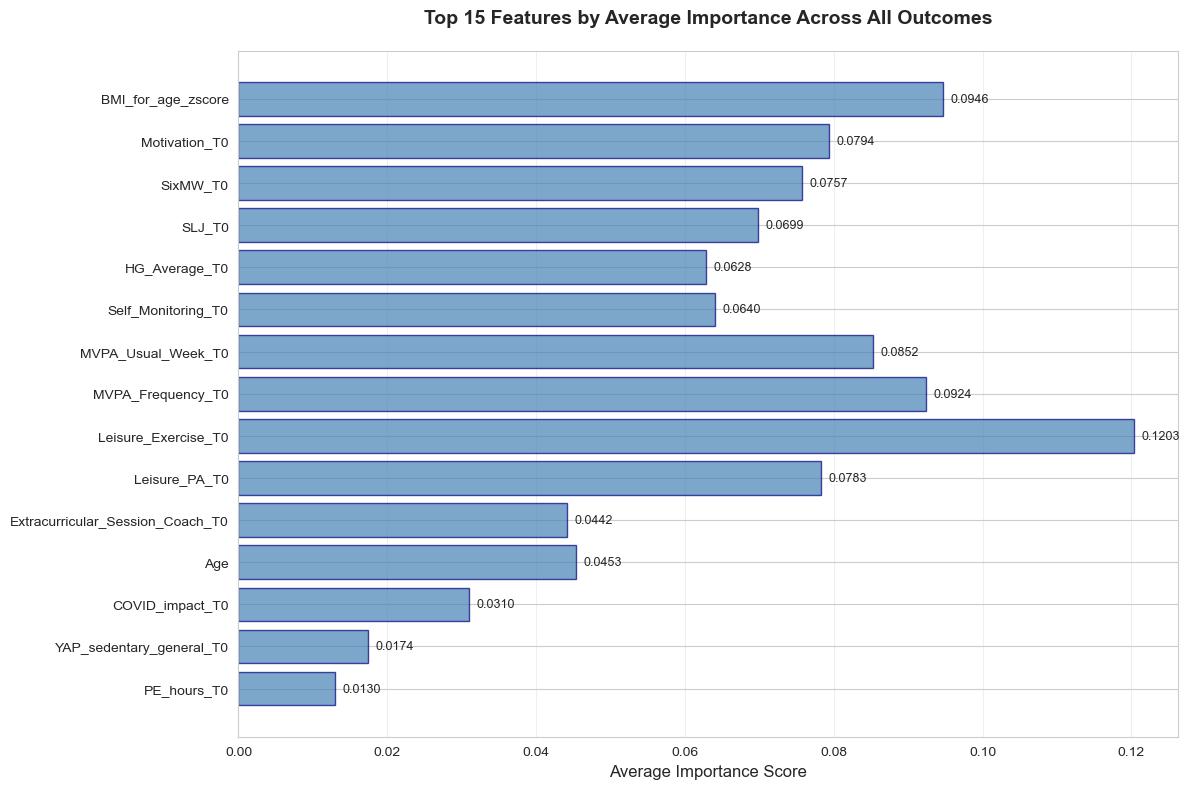

✓ Plotted top 15 features by average importance


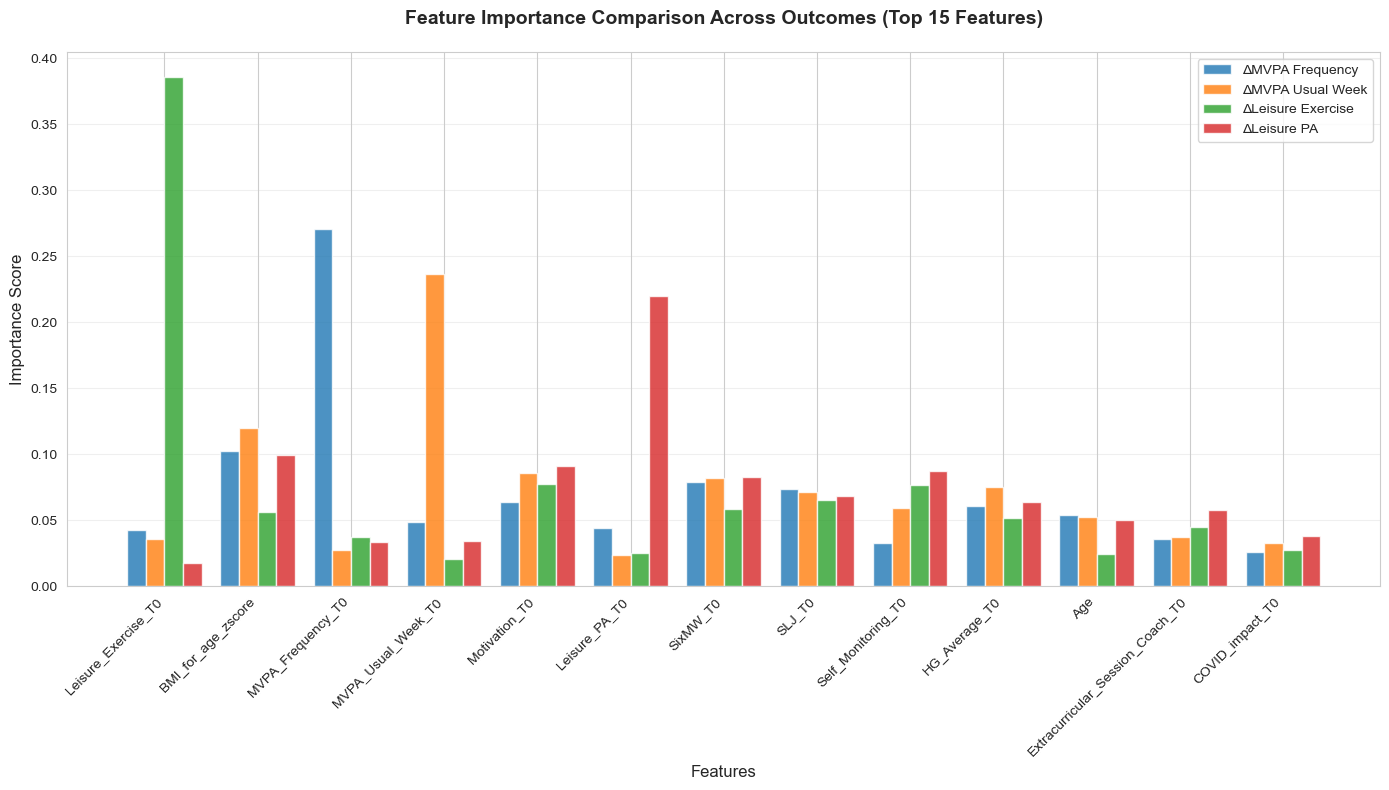

✓ Plotted feature importance comparison across 4 outcomes


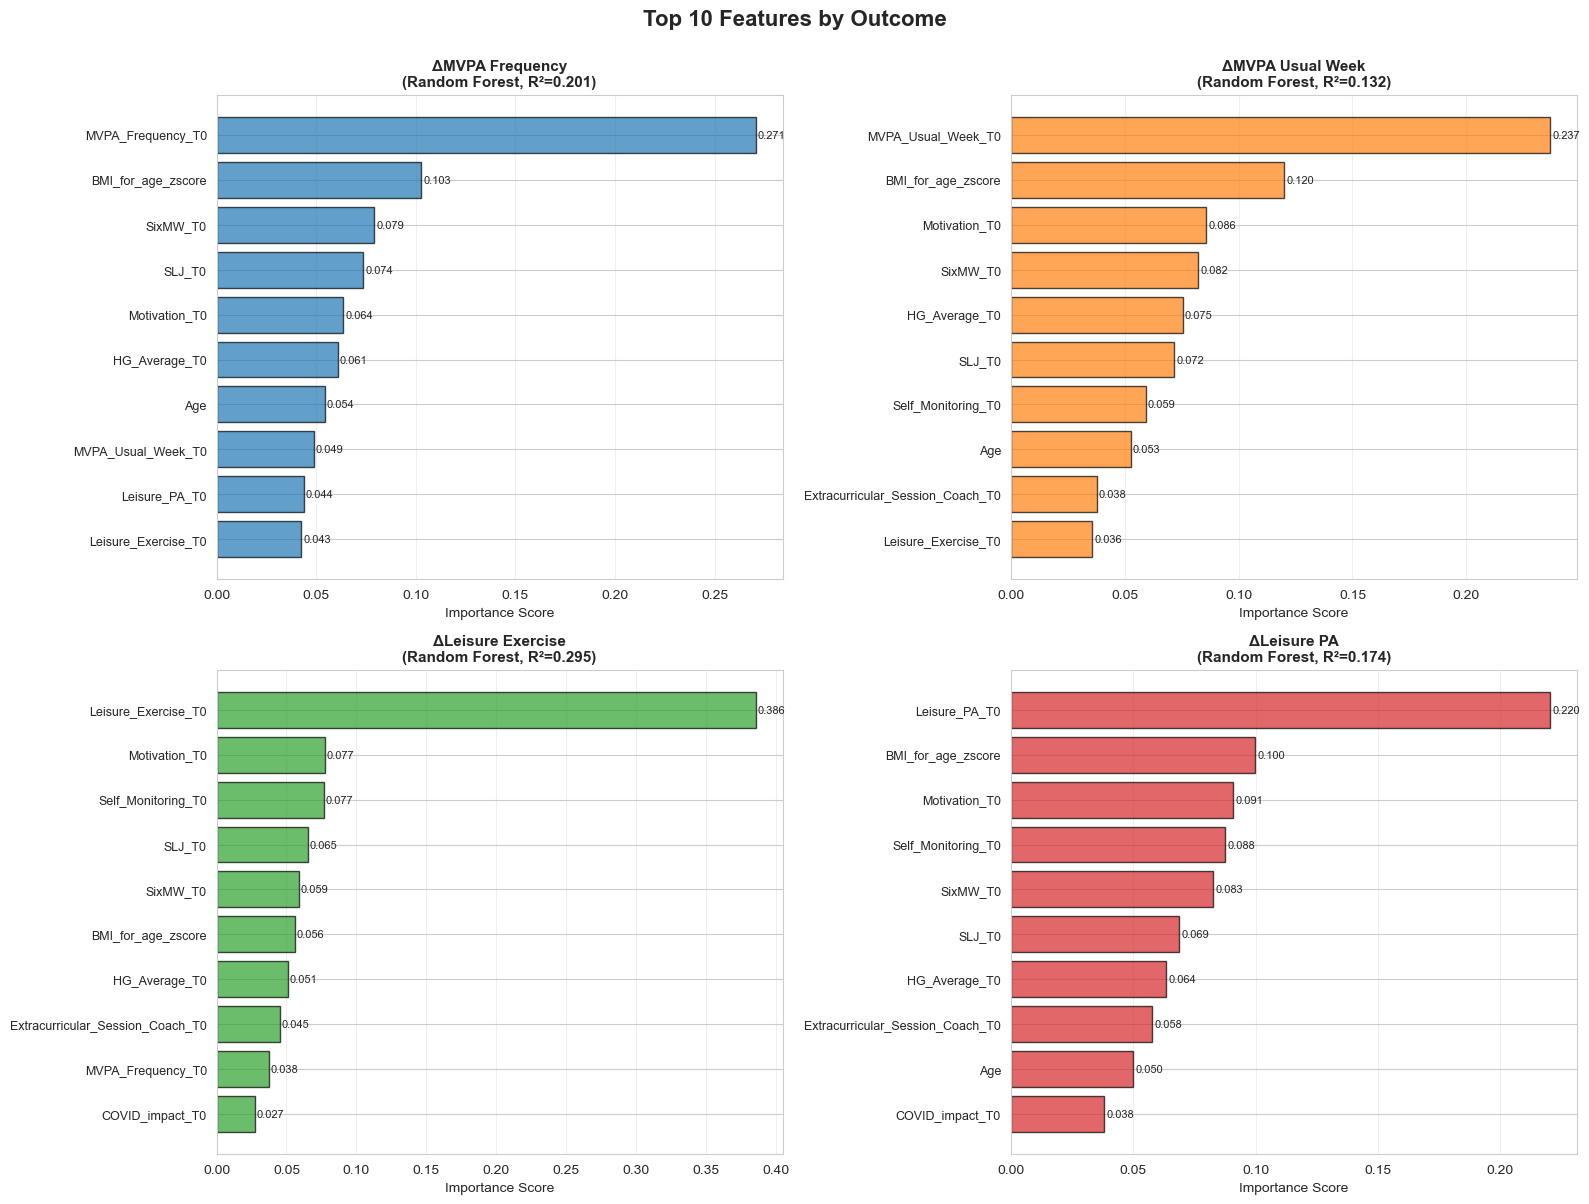

✓ Plotted top 10 features for each of 4 outcomes


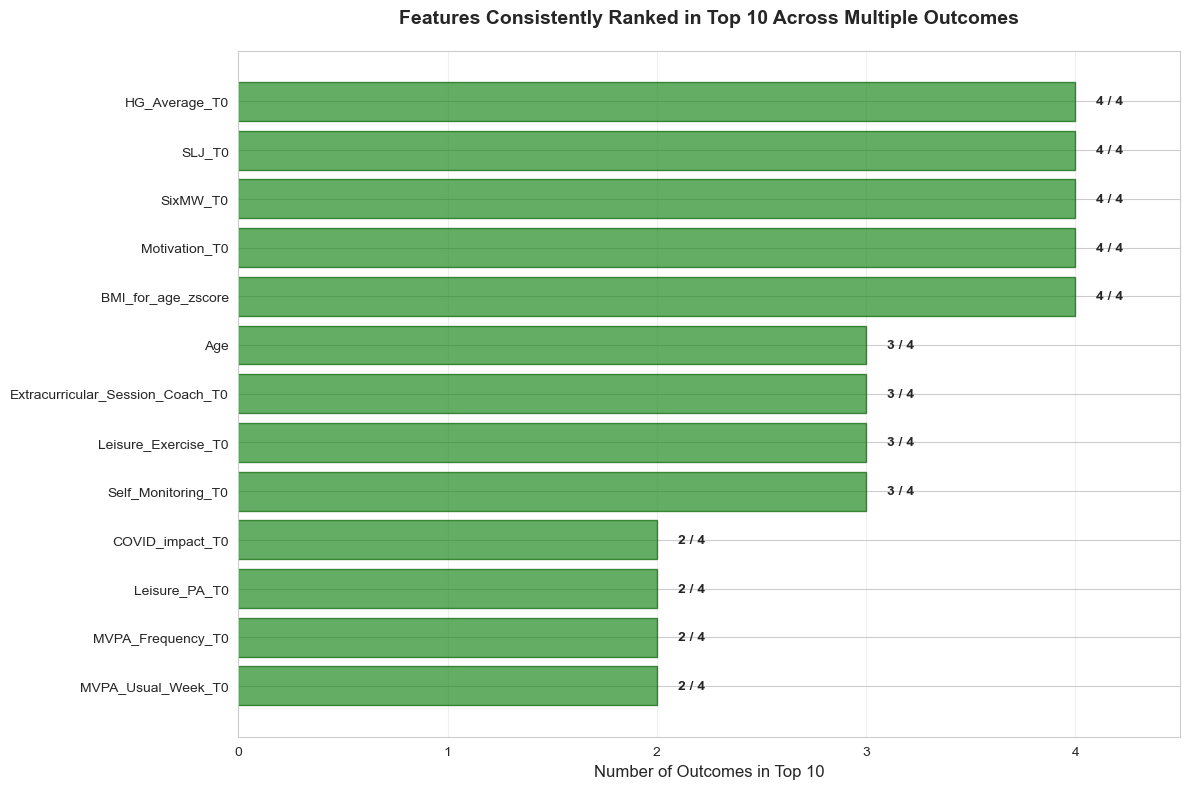

✓ Plotted consistency analysis for 13 features


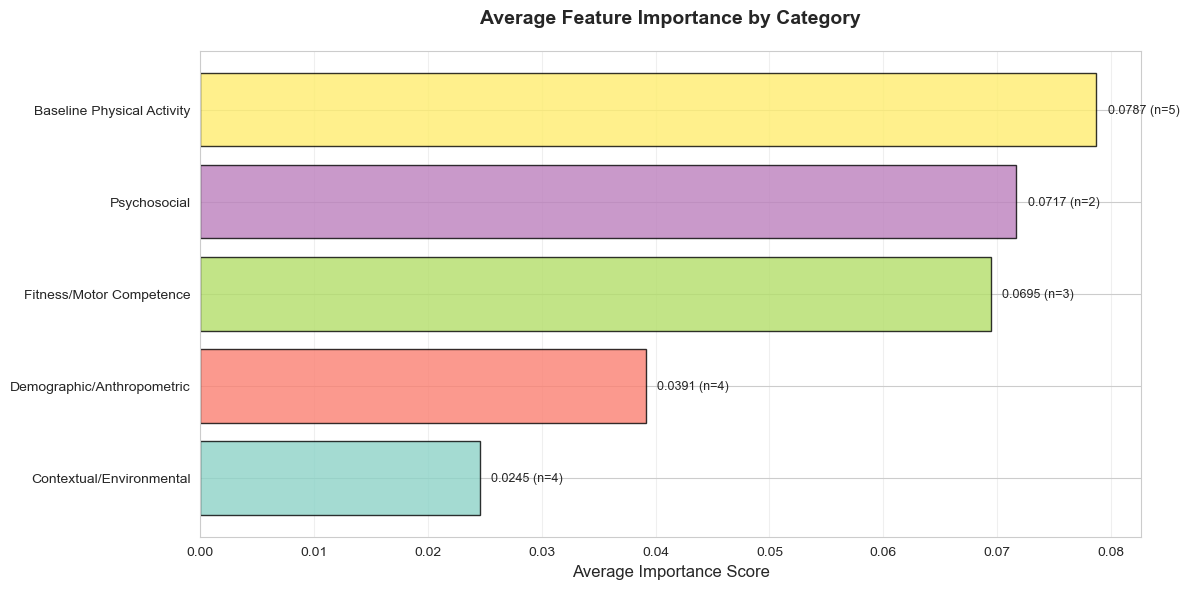

✓ Plotted importance by category for 5 categories


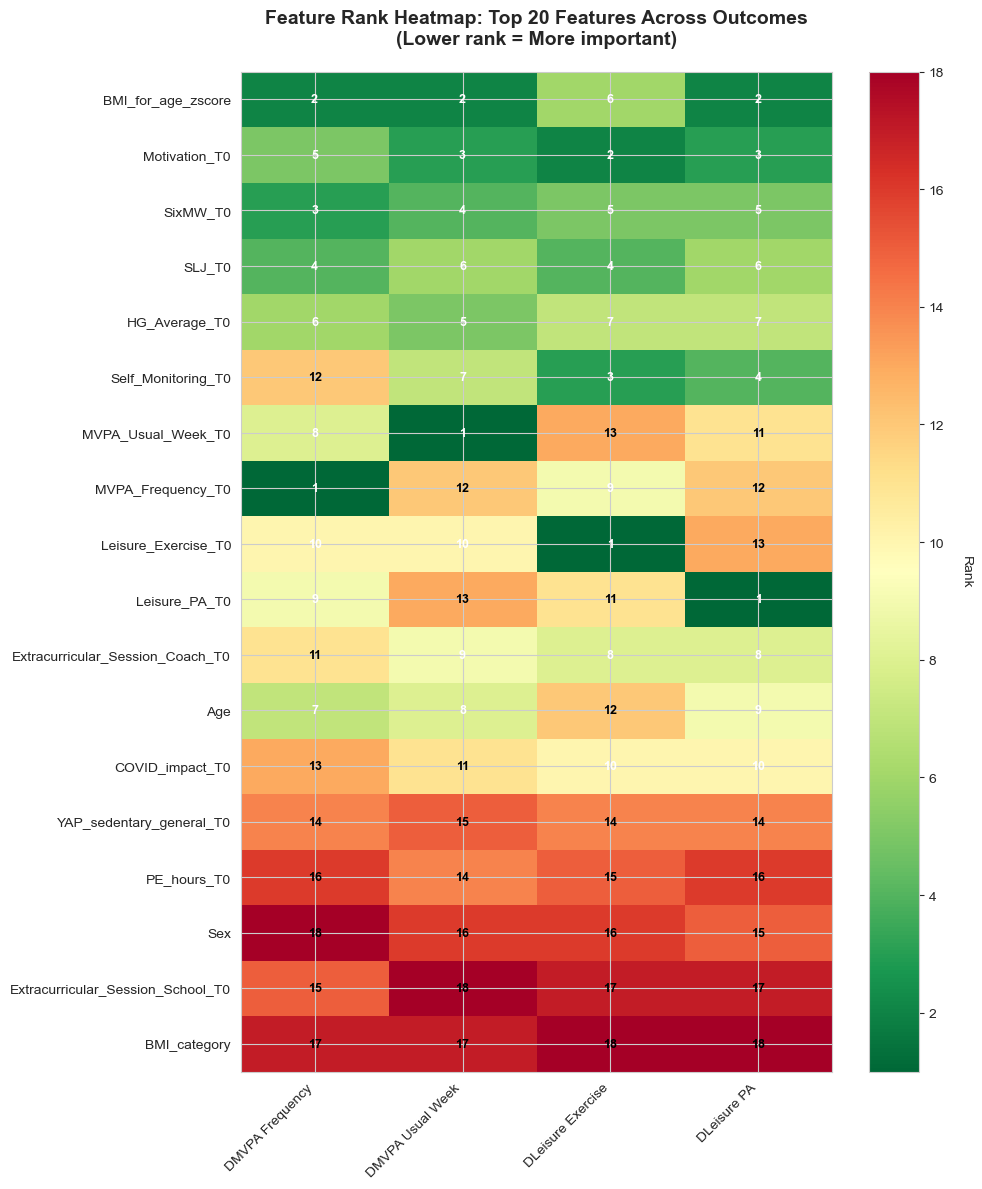

✓ Plotted rank heatmap for top 20 features across 4 outcomes

VISUALIZATION COMPLETE


In [ ]:
# 1. Top 15 Features by Average Importance Across All Outcomes
# =============================================================================
if len(importance_data) > 0:
    fig, ax = plt.subplots(figsize=(12, 8))
    
    top_15_features = summary_df.head(15).copy()
    
    ax.barh(range(len(top_15_features)), top_15_features['Avg_Importance'], 
            color='steelblue', alpha=0.7, edgecolor='navy')
    ax.set_yticks(range(len(top_15_features)))
    ax.set_yticklabels(top_15_features['Feature'])
    ax.set_xlabel('Average Importance Score', fontsize=12)
    ax.set_title('Top 15 Features by Average Importance Across All Outcomes', 
                 fontsize=14, fontweight='bold', pad=20)
    ax.invert_yaxis()
    ax.grid(axis='x', alpha=0.3)
    
    # Add value labels
    for i, (idx, row) in enumerate(top_15_features.iterrows()):
        ax.text(row['Avg_Importance'] + 0.001, i, f"{row['Avg_Importance']:.4f}", 
               va='center', fontsize=9)
    
    plt.tight_layout()
    plt.show()
    
    print(f"✓ Plotted top 15 features by average importance")


# 2. Feature Importance by Outcome (Side-by-Side Comparison)
# =============================================================================
if len(importance_data) > 0:
    # Get union of top 10 features across all outcomes
    all_top_features = set()
    for outcome, data_dict in importance_data.items():
        top_10 = data_dict['df'].head(10)['Feature'].tolist()
        all_top_features.update(top_10)
    
    # Create comparison dataframe
    comparison_data = []
    for feature in all_top_features:
        row = {'Feature': feature}
        for outcome, data_dict in importance_data.items():
            df = data_dict['df']
            importance = df[df['Feature'] == feature]['Importance'].values
            row[outcome] = importance[0] if len(importance) > 0 else 0
        comparison_data.append(row)
    
    comparison_df = pd.DataFrame(comparison_data)
    
    # Sort by average importance
    outcome_cols = list(importance_data.keys())
    comparison_df['Avg'] = comparison_df[outcome_cols].mean(axis=1)
    comparison_df = comparison_df.sort_values('Avg', ascending=False).head(15)
    
    # Plot grouped bar chart
    fig, ax = plt.subplots(figsize=(14, 8))
    
    x = np.arange(len(comparison_df))
    width = 0.2
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']
    
    for i, (outcome, color) in enumerate(zip(outcome_cols, colors)):
        offset = width * (i - 1.5)
        bars = ax.bar(x + offset, comparison_df[outcome], width, 
                      label=outcome, color=color, alpha=0.8)
    
    ax.set_xlabel('Features', fontsize=12)
    ax.set_ylabel('Importance Score', fontsize=12)
    ax.set_title('Feature Importance Comparison Across Outcomes (Top 15 Features)', 
                 fontsize=14, fontweight='bold', pad=20)
    ax.set_xticks(x)
    ax.set_xticklabels(comparison_df['Feature'], rotation=45, ha='right')
    ax.legend(loc='upper right')
    ax.grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print(f"✓ Plotted feature importance comparison across {len(outcome_cols)} outcomes")


# 3. Top Features per Outcome (Individual Bar Charts)
# =============================================================================
if len(importance_data) > 0:
    n_outcomes = len(importance_data)
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    axes = axes.flatten()
    
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']
    
    for idx, (outcome, data_dict) in enumerate(importance_data.items()):
        ax = axes[idx]
        top_10 = data_dict['df'].head(10)
        
        ax.barh(range(len(top_10)), top_10['Importance'], 
               color=colors[idx], alpha=0.7, edgecolor='black')
        ax.set_yticks(range(len(top_10)))
        ax.set_yticklabels(top_10['Feature'], fontsize=9)
        ax.set_xlabel('Importance Score', fontsize=10)
        ax.set_title(f'{outcome}\n({data_dict["model_name"]}, R²={data_dict["r2"]:.3f})', 
                    fontsize=11, fontweight='bold')
        ax.invert_yaxis()
        ax.grid(axis='x', alpha=0.3)
        
        # Add value labels
        for i, (_, row) in enumerate(top_10.iterrows()):
            ax.text(row['Importance'] + 0.001, i, f"{row['Importance']:.3f}", 
                   va='center', fontsize=8)
    
    plt.suptitle('Top 10 Features by Outcome', fontsize=16, fontweight='bold', y=1.00)
    plt.tight_layout()
    plt.show()
    
    print(f"✓ Plotted top 10 features for each of {n_outcomes} outcomes")


# 4. Consistency Analysis: Features in Top 10 Across Multiple Outcomes
# =============================================================================
if len(importance_data) > 0:
    consistent_features = summary_df[summary_df['N_Outcomes_Top10'] >= 2].sort_values(
        'N_Outcomes_Top10', ascending=True
    )
    
    if len(consistent_features) > 0:
        fig, ax = plt.subplots(figsize=(12, 8))
        
        ax.barh(range(len(consistent_features)), consistent_features['N_Outcomes_Top10'], 
               color='forestgreen', alpha=0.7, edgecolor='darkgreen')
        ax.set_yticks(range(len(consistent_features)))
        ax.set_yticklabels(consistent_features['Feature'])
        ax.set_xlabel('Number of Outcomes in Top 10', fontsize=12)
        ax.set_title('Features Consistently Ranked in Top 10 Across Multiple Outcomes', 
                    fontsize=14, fontweight='bold', pad=20)
        ax.set_xlim(0, 4.5)
        ax.set_xticks([0, 1, 2, 3, 4])
        ax.grid(axis='x', alpha=0.3)
        
        # Add value labels
        for i, (_, row) in enumerate(consistent_features.iterrows()):
            ax.text(row['N_Outcomes_Top10'] + 0.1, i, 
                   f"{int(row['N_Outcomes_Top10'])} / 4", 
                   va='center', fontsize=10, fontweight='bold')
        
        plt.tight_layout()
        plt.show()
        
        print(f"✓ Plotted consistency analysis for {len(consistent_features)} features")
    else:
        print("No features appear in top 10 for multiple outcomes - skipping consistency plot")


# 5. Feature Category Importance
# =============================================================================
if len(importance_data) > 0:
    fig, ax = plt.subplots(figsize=(12, 6))
    
    category_sorted = category_importance.sort_values('Avg_Importance', ascending=True)
    
    colors_cat = plt.cm.Set3(np.linspace(0, 1, len(category_sorted)))
    
    bars = ax.barh(range(len(category_sorted)), category_sorted['Avg_Importance'], 
           color=colors_cat, alpha=0.8, edgecolor='black')
    ax.set_yticks(range(len(category_sorted)))
    ax.set_yticklabels(category_sorted.index)
    ax.set_xlabel('Average Importance Score', fontsize=12)
    ax.set_title('Average Feature Importance by Category', 
                fontsize=14, fontweight='bold', pad=20)
    ax.grid(axis='x', alpha=0.3)
    
    # Add value labels and feature count
    for i, (cat, row) in enumerate(category_sorted.iterrows()):
        ax.text(row['Avg_Importance'] + 0.001, i, 
               f"{row['Avg_Importance']:.4f} (n={int(row['N_Features'])})", 
               va='center', fontsize=9)
    
    plt.tight_layout()
    plt.show()
    
    print(f"✓ Plotted importance by category for {len(category_sorted)} categories")


# 6. Heatmap: Feature Ranks Across Outcomes
# =============================================================================
if len(importance_data) > 0:
    # Create rank matrix for top 20 features
    top_features_list = summary_df.head(20)['Feature'].tolist()
    
    rank_matrix = []
    for feature in top_features_list:
        ranks = []
        for outcome in importance_data.keys():
            rank = all_feature_ranks[feature]['ranks'].get(outcome, None)
            ranks.append(rank if rank is not None else np.nan)
        rank_matrix.append(ranks)
    
    rank_df = pd.DataFrame(
        rank_matrix, 
        index=top_features_list,
        columns=[o.replace('Δ', 'D')[:20] for o in importance_data.keys()]
    )
    
    fig, ax = plt.subplots(figsize=(10, 12))
    
    # Create heatmap (lower rank = darker color = more important)
    im = ax.imshow(rank_df.values, cmap='RdYlGn_r', aspect='auto', vmin=1, vmax=len(baseline_features))
    
    # Set ticks
    ax.set_xticks(np.arange(len(rank_df.columns)))
    ax.set_yticks(np.arange(len(rank_df.index)))
    ax.set_xticklabels(rank_df.columns, rotation=45, ha='right')
    ax.set_yticklabels(rank_df.index)
    
    # Add rank numbers in cells
    for i in range(len(rank_df.index)):
        for j in range(len(rank_df.columns)):
            rank = rank_df.iloc[i, j]
            if not np.isnan(rank):
                text = ax.text(j, i, int(rank), ha="center", va="center", 
                             color="black" if rank > 10 else "white", 
                             fontweight='bold', fontsize=9)
    
    ax.set_title('Feature Rank Heatmap: Top 20 Features Across Outcomes\n(Lower rank = More important)', 
                fontsize=14, fontweight='bold', pad=20)
    
    # Add colorbar
    cbar = plt.colorbar(im, ax=ax)
    cbar.set_label('Rank', rotation=270, labelpad=20)
    
    plt.tight_layout()
    plt.show()
    
    print(f"✓ Plotted rank heatmap for top 20 features across {len(importance_data)} outcomes")

print("\n" + "="*80)
print("VISUALIZATION COMPLETE")
print("="*80)